In [1]:
import time
from tqdm import tqdm
from parse_LightGCN import parse_args
import torch
import os
from torch.utils.data import DataLoader
from ogb.linkproppred import Evaluator

from utils import *
from model import LightGCN
from dataprocess import General_dataset, load_data, normalize_edge_gcn
import math
from torch_sparse import SparseTensor

import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams["font.family"] = "Times New Roman"

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import argparse


def parse_args():
    parser = argparse.ArgumentParser()

    # dataset
    parser.add_argument("--dataset", nargs="?", default="ogbl-collab")

    # model
    parser.add_argument("--model", type=str, default="LightGCN")
    parser.add_argument("--n_layers", type=int, default=1)
    parser.add_argument("--n_hidden", type=int, default=256)

    # training
    parser.add_argument('--epochs', type=int, default=1000)
    parser.add_argument('--batch_size', type=int, default=64 * 1024)
    parser.add_argument('--test_batch_size', type=int, default=1024)
    parser.add_argument('--num_workers', type=int, default=0)
    parser.add_argument('--pin_memory', type=int, default=0)
    parser.add_argument('--encoder_lr', type=float, default=1e-3)
    parser.add_argument('--predictor_lr', type=float, default=1e-2)
    parser.add_argument('--dropout', type=float, default=0.0)

    # specific for LP
    parser.add_argument("--n_neg", type=int, default=1, help="number of negative in K-pair loss")
    parser.add_argument('--topks', default=[5, 10, 20, 50, 100])

    # experiments
    parser.add_argument("--seed", type=int, default=1028,
                        help="seed to run the experiment")
    parser.add_argument("--early_stop", type=int, default=20,
                        help="early_stopping by which epoch*5")
    parser.add_argument("--eval_steps", type=int, default=1)
    parser.add_argument("--runs", type=int, default=5)
    parser.add_argument("--save", action = 'store_true')
    parser.add_argument("--train", action = 'store_true')
    parser.add_argument("--load", action = 'store_true')
    parser.add_argument('--model_name', type=str, default='LightGCN')

    parser.add_argument("--encoder_name", type=str, default='encoder')
    parser.add_argument("--predictor_name", type=str, default='predictor')

    parser.add_argument("--tc", type=str, default='tc')
    parser.add_argument("--tc_layer", type=int, default=1)

    parser.add_argument('--eval_node_type', type=str, default='Test')

    return parser.parse_args()


In [3]:
import sys
sys.argv = ['']
args = parse_args()
args

Namespace(batch_size=65536, dataset='ogbl-collab', dropout=0.0, early_stop=20, encoder_lr=0.001, encoder_name='encoder', epochs=1000, eval_node_type='Test', eval_steps=1, load=False, model='LightGCN', model_name='LightGCN', n_hidden=256, n_layers=1, n_neg=1, num_workers=0, pin_memory=0, predictor_lr=0.01, predictor_name='predictor', runs=5, save=False, seed=1028, tc='tc', tc_layer=1, test_batch_size=1024, topks=[5, 10, 20, 50, 100], train=False)

In [4]:
for _ in range(1):
    args = parse_args()

    args.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    args.path = os.getcwd()

    print(args)

    seed_everything(args.seed)

    """build dataset"""
    data, edge, adj_list_dict, neg_edge, test_node, eval_node, args.deg, args.tc, args.atc, args.density, args.n_nodes, args.n_edges = load_data(args)

    print('# of nodes:', args.n_nodes)
    print('# of edges:', args.n_edges)
    print('# of training edges:', edge['Train'].shape[0])
    print('# of validation edges:', edge['Val'].shape[0])
    print('# of testing edges:', edge['Test'].shape[0])
    print('Network density:', args.n_edges * 2 / (args.n_nodes * (args.n_nodes - 1)))
    
    for key in args.tc:
        print('TC-' + key, np.mean(np.array(args.tc[key])[test_node.numpy()]))

Namespace(batch_size=65536, dataset='ogbl-collab', device=device(type='cuda'), dropout=0.0, early_stop=20, encoder_lr=0.001, encoder_name='encoder', epochs=1000, eval_node_type='Test', eval_steps=1, load=False, model='LightGCN', model_name='LightGCN', n_hidden=256, n_layers=1, n_neg=1, num_workers=0, path='/home/yu/Dropbox/Project/ICLR-TC-analysis', pin_memory=0, predictor_lr=0.01, predictor_name='predictor', runs=5, save=False, seed=1028, tc='tc', tc_layer=1, test_batch_size=1024, topks=[5, 10, 20, 50, 100], train=False)
# of nodes: 235868
# of edges: 1074045
# of training edges: 967632
# of validation edges: 60084
# of testing edges: 46329
Network density: 3.8611463715130124e-05
TC-train_train 0.49777879645063955
TC-train_val 0.1355711694069623
TC-train_test 0.21655367572820286


In [5]:
def group_by_deg_lcc(val, deg, lcc, deg_group_num, interval, threshold):
    #normal: group - 7, interval - 100, threshold - inf
    #cold: group - 10, interval - 10, threshold - 100
    #colder: group - 10, interval - 1, threshold - 10
    
    vall, count = np.zeros((5, deg_group_num)), np.zeros((5, deg_group_num))
    
    for r, d, l in zip(val, deg, lcc):
        if d < threshold:
        
            idx = int(l//0.2)
            idx3 = int(d//interval)

            vall[idx, idx3] += r
            count[idx, idx3] += 1
            
    vall = vall/count
    
    return vall

def ratio_group_by_deg_lcc(deg, lcc, deg_group_num, interval, threshold):
    #normal: group - 7, interval - 100, threshold - inf
    #cold: group - 10, interval - 10, threshold - 100
    #colder: group - 10, interval - 1, threshold - 10
    
    count = np.zeros((5, deg_group_num))
    
    for d, l in zip(deg, lcc):
        if d <= threshold:
        
            idx = int(l//0.2)
            idx3 = int(d//interval) - 1

            count[idx, idx3] += 1
    
#     count /= len(deg)
    
    return count

def ratio_group_by_deg_lcc2(deg, lcc, deg_group_num, interval, threshold):
    #normal: group - 7, interval - 100, threshold - inf
    #cold: group - 10, interval - 10, threshold - 100
    #colder: group - 10, interval - 1, threshold - 10
    
    count = np.zeros((5, deg_group_num))
    
    for d, l in zip(deg, lcc):
        if d <= threshold:
        
            idx = int(l//0.2)
            idx3 = int(d//interval)

            count[idx, idx3] += 1
    
#     count /= len(deg)
    
    return count

def group_by_tc_dist(val, tc):
    vall, count = np.zeros((5, val.shape[0])), np.zeros(5)
    
    for i in range(val.shape[1]):
        idx = int(tc[i]/0.4) + 2
        
        vall[idx] += val[:, i]
        count[idx] += 1
            
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1)

In [6]:
split = 'Val'

val_recalls, val_ndcgs, val_hits, val_f1s, val_precisions, val_scores, val_mrrs = [], [], [], [], [], [], []
for run in range(args.runs):
    val_recalls.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_recall_list_' + split + '.npy'))
    val_ndcgs.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) +'_ndcg_list_' + split + '.npy'))
    val_hits.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) +'_hit_ratio_list_' + split + '.npy'))
    val_f1s.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_F1_list_' + split + '.npy'))
    val_precisions.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_precision_list_' + split + '.npy'))
    val_mrrs.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_mrr_list_' + split + '.npy'))


val_recalls = np.stack(val_recalls, axis = 0)
val_ndcgs = np.stack(val_ndcgs, axis = 0)
val_hits = np.stack(val_hits, axis = 0)
val_f1s = np.stack(val_f1s, axis = 0)
val_precisions = np.stack(val_precisions, axis = 0)
val_mrrs = np.stack(val_mrrs, axis = 0)

#MEAN: x.mean(axis = 1).mean(axis = 0)
#STD: x.mean(axis = 1).std(axis = 0)

val_metrics = [val_precisions, val_f1s, val_ndcgs, val_recalls, val_mrrs, val_hits]

In [7]:
keys = ['Precision', 'F1', 'NDCG', 'Recall',  'MRR', r'Hits$^N$']

In [8]:
split = 'Test'

test_recalls, test_ndcgs, test_hits, test_f1s, test_precisions, test_mrrs = [], [], [], [], [], []
for run in range(args.runs):
    test_recalls.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_recall_list_' + split + '.npy'))
    test_ndcgs.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) +'_ndcg_list_' + split + '.npy'))
    test_hits.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) +'_hit_ratio_list_' + split + '.npy'))
    test_f1s.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_F1_list_' + split + '.npy'))
    test_precisions.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_precision_list_' + split + '.npy'))
    test_mrrs.append(np.load('./res/' + args.dataset + '/' + args.model_name + '/' + str(run) + '_mrr_list_' + split + '.npy'))


test_recalls = np.stack(test_recalls, axis = 0)
test_ndcgs = np.stack(test_ndcgs, axis = 0)
test_hits = np.stack(test_hits, axis = 0)
test_f1s = np.stack(test_f1s, axis = 0)
test_precisions = np.stack(test_precisions, axis = 0)
test_mrrs = np.stack(test_mrrs, axis = 0)

#MEAN: x.mean(axis = 1).mean(axis = 0)
#STD: x.mean(axis = 1).std(axis = 0)

test_metrics = [test_precisions, test_f1s, test_ndcgs, test_recalls, test_mrrs, test_hits]

In [9]:
for key, metric in zip(keys, val_metrics):
    print(key, metric.mean(axis = 1).mean(axis = 0), metric.mean(axis = 1).std(axis = 0))

Precision [0.1187 0.0863 0.0593 0.0335 0.0214] [0.0033 0.0021 0.001  0.0003 0.0002]
F1 [0.127  0.1142 0.0907 0.0579 0.0388] [0.0036 0.0027 0.0015 0.0006 0.0003]
NDCG [0.1914 0.2129 0.2375 0.2675 0.2876] [0.0052 0.0052 0.005  0.0046 0.0044]
Recall [0.1847 0.2514 0.3235 0.4235 0.5004] [0.0049 0.0053 0.0048 0.0032 0.0024]
MRR 0.3171996668850317 0.005270692719559607
Hits$^N$ [0.4364 0.5342 0.6226 0.7217 0.7824] [0.0063 0.0043 0.0026 0.001  0.0007]


In [10]:
for key, metric in zip(keys, test_metrics):
    print(key, metric.mean(axis = 1).mean(axis = 0), metric.mean(axis = 1).std(axis = 0))

Precision [0.0891 0.0633 0.0434 0.0249 0.0158] [2.0676e-03 1.3626e-03 6.3793e-04 1.8003e-04 9.9011e-05]
F1 [0.1008 0.0876 0.0687 0.044  0.0293] [0.0024 0.0019 0.001  0.0003 0.0002]
NDCG [0.1571 0.175  0.1959 0.2209 0.2378] [0.0039 0.0041 0.0039 0.0036 0.0035]
Recall [0.1601 0.2146 0.2763 0.3617 0.4286] [0.0037 0.0042 0.0036 0.0023 0.0018]
MRR 0.25755096735668176 0.004739576257806995
Hits$^N$ [0.3557 0.4465 0.5357 0.6396 0.7058] [0.006  0.0038 0.0029 0.0008 0.0004]


In [11]:
train_deg = np.array(args.deg['Train'])[test_node]
test_deg = np.array(args.deg['Test'])[test_node]

tc_val_node = {'train': np.array(args.tc['train_train'])[eval_node['Val']], \
               'val': np.array(args.tc['train_val'])[eval_node['Val']],\
               'test': np.array(args.tc['train_test'])[eval_node['Val']]}

tc_test_node = {'train': np.array(args.tc['train_train'])[eval_node['Test']], \
                'val': np.array(args.tc['train_val'])[eval_node['Test']],\
                'test': np.array(args.tc['train_test'])[eval_node['Test']]}

In [12]:
density = np.array(args.density)[test_node]

## Perform post analysis
### 1. Degree vs Performance
#### 1.1 Degree vs Val Performance (Cold and Non-Cold)
#### 1.2 Degree vs Test Performance (Cold and Non-Cold)

### 2. TC vs Performance
#### 2.1 Train-TC vs Val Performance (Cold and Non-Cold)
#### 2.2 Train-TC vs Test Performance (Cold and Non-Cold)
#### 2.3 Val-TC vs Val Performance (Cold and Non-Cold)
#### 2.4 Va-TC vs Test Performance (Cold and Non-Cold)

### 3. Degree vs TC
#### 3.1. Train-TC vs Degree (Cold and Non-Cold)
#### 3.2. Val-TC vs Degree (Cold and Non-Cold)

In [135]:
def group_by_deg(val, deg, deg_group_num, interval, threshold):
    vall, count = np.zeros((deg_group_num, val.shape[0])), np.zeros(deg_group_num)
    
    for i in range(val.shape[1]):
        d = deg[i]
        
        if d < threshold:
            idx = min(int(d//interval), deg_group_num - 1)

            vall[idx] += val[:, i]
            count[idx] += 1
            
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1)


def group_by_deg_log(val, deg, threshold, base):
    deg2 = deg
    deg2[deg2 == 0] = 1
    log_deg2 = np.emath.logn(base, deg2).astype(int)
    
    log_threshold = np.emath.logn(base, np.array(threshold)).astype(int)

    unique_log_deg2 = np.unique(log_deg2)
    log_deg2 -= unique_log_deg2[0]
    
    group_num = (unique_log_deg2 < log_threshold).sum().item()
    vall, count = np.zeros((group_num, val.shape[0])), np.zeros(group_num)
    
    for i in range(val.shape[1]):
        d = log_deg2[i]
        
        if d < log_threshold - unique_log_deg2[0]:
            idx = d

            vall[idx] += val[:, i]
            count[idx] += 1
            
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1), np.unique(log_deg2[log_deg2 < log_threshold])


def group_by_tc(val, tc, group_num, interval, threshold):
    vall, count = np.zeros((group_num, val.shape[0])), np.zeros(group_num)
    
    for i in range(val.shape[1]):
        if tc[i] <= threshold:
            # idx = int(tc[i]//interval)
            idx = min(int(tc[i]//interval), group_num - 1)

            vall[idx] += val[:, i]
            count[idx] += 1
            
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1)

def group_by_tc_log(val, tc, threshold, base):
    tc2 = tc
    tc2[tc2 == 0] = min(tc[tc != 0])
    log_tc2 = np.emath.logn(base, tc2).astype(int)
    
    
    log_threshold = np.emath.logn(base, np.array(threshold)).astype(int)

    unique_log_tc2 = np.unique(log_tc2)
    log_tc2 -= unique_log_tc2[0]
    
    group_num = (unique_log_tc2 < log_threshold).sum().item()
    vall, count = np.zeros((group_num, val.shape[0])), np.zeros(group_num)
    
    
    for i in range(val.shape[1]):
        d = log_tc2[i]
        
        if d < log_threshold - unique_log_tc2[0]:
            idx = d

            vall[idx] += val[:, i]
            count[idx] += 1
          
    vall = vall/count.reshape(-1, 1)
    
    return vall.mean(axis = 1), vall.std(axis = 1), np.unique(log_tc2[log_tc2 < log_threshold])

In [136]:
class analysis(object):
    def __init__(self, tc_val_node, tc_test_node):
        self.tc_val_node = tc_val_node
        self.tc_test_node = tc_test_node
    
    def deg_perform(self, keys, metrics, deg, xticklabels, args, group_num, interval, upper_limit, file_name, xlabel):
        mean_vs, std_vs, labels = [], [], []

        for key, metric in zip(keys, metrics):
            labels.append(key)

            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v = group_by_deg(metric[:, :, 1], deg, group_num, interval, upper_limit)
            else:
                title = key
                mean_v, std_v = group_by_deg(metric, deg, group_num, interval, upper_limit)

            mean_vs.append(mean_v)
            std_vs.append(std_v)

        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)


        # Create an array with the positions of the bars along the x-axis
        # The number of groups and the number of bars per group are defined by the data's shape
        num_groups, num_bars_per_group = mean_vs.shape
        group_width = 0.8
        bar_width = group_width / num_bars_per_group
        x = np.arange(num_groups)

        # Create the bar chart
        fig, ax = plt.subplots(figsize = (15, 5))

        for i in range(num_bars_per_group):
            ax.bar(x + i * bar_width, mean_vs[:, i], width=bar_width, label = labels[i], yerr = std_vs[:, i])

        # Customize the plot
        ax.set_xticks(x + (num_bars_per_group - 1) / 2 * bar_width)
        ax.set_xticklabels(xticklabels, fontsize = 15)
        ax.tick_params('y', labelsize = 15)
        ax.set_xlabel(xlabel, fontsize = 20, fontweight = 'bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize = 20, fontweight = 'bold')

        ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), frameon = 0)


        #Show the plot
        plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')
    
    def log_deg_perform(self, keys, metrics, deg, xticklabels, args, upper_limit, base, file_name):
        mean_vs, std_vs, labels = [], [], []

        for key, metric in zip(keys, metrics):
            labels.append(key)

            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v, unique_val = group_by_deg_log(metric[:, :, 1], deg, upper_limit, base)
            else:
                title = key
                mean_v, std_v, unique_val = group_by_deg_log(metric, deg, upper_limit, base)

            mean_vs.append(mean_v)
            std_vs.append(std_v)

        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)

        # print(mean_vs.shape, std_vs.shape)


        # Create an array with the positions of the bars along the x-axis
        # The number of groups and the number of bars per group are defined by the data's shape
        num_groups, num_bars_per_group = mean_vs.shape
        group_width = 0.8
        bar_width = group_width / num_bars_per_group
        x = np.arange(num_groups)

        # Create the bar chart
        fig, ax = plt.subplots(figsize = (15, 5))

        for i in range(num_bars_per_group):
            ax.bar(x + i * bar_width, mean_vs[:, i], width=bar_width, label = labels[i], yerr = std_vs[:, i])

        # num_groups, num_bars_per_group = mean_vs.shape
        # xticklabels = all_xticklabels[:num_groups]
        # Customize the plot
        ax.set_xticks(x + (num_bars_per_group - 1) / 2 * bar_width)
        ax.set_xticklabels(xticklabels, fontsize = 15)
        ax.tick_params('y', labelsize = 15)
        ax.set_xlabel('Train-Degree Group', fontsize = 20, fontweight = 'bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize = 20, fontweight = 'bold')

        ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), frameon = 0)


        #Show the plot
        plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')
        
        return unique_val
    
    def tc_perform(self, keys, metrics, tc, xticklabels, args, group_num, interval, upper_limit, file_name, xlabel):
        mean_vs, std_vs, labels = [], [], []

        for key, metric in zip(keys, metrics):
            labels.append(key)

            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v = group_by_tc(metric[:, :, 1], tc, group_num, interval, upper_limit)
            else:
                title = key
                mean_v, std_v = group_by_tc(metric, tc, group_num, interval, upper_limit)

            mean_vs.append(mean_v)
            std_vs.append(std_v)

        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)


        # Create an array with the positions of the bars along the x-axis
        # The number of groups and the number of bars per group are defined by the data's shape
        num_groups, num_bars_per_group = mean_vs.shape
        group_width = 0.8
        bar_width = group_width / num_bars_per_group
        x = np.arange(num_groups)

        # Create the bar chart
        fig, ax = plt.subplots(figsize = (15, 5))

        for i in range(num_bars_per_group):
            ax.bar(x + i * bar_width, mean_vs[:, i], width=bar_width, label = labels[i], yerr = std_vs[:, i])

        # Customize the plot
        ax.set_xticks(x + (num_bars_per_group - 1) / 2 * bar_width)
        ax.set_xticklabels(xticklabels, fontsize = 15)
        ax.tick_params('y', labelsize = 15)
        ax.set_xlabel(xlabel, fontsize = 20, fontweight = 'bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize = 20, fontweight = 'bold')

        ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), frameon = 0)


        #Show the plot
        plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')
                            
    def log_tc_perform(self, keys, metrics, tc, xticklabels, args, upper_limit, base, file_name):
        mean_vs, std_vs, labels = [], [], []

        for key, metric in zip(keys, metrics):
            labels.append(key)

            if key not in ['MRR']:
                title = key + '@' + str(args.topks[1])
                mean_v, std_v, unique_val = group_by_tc_log(metric[:, :, 1], tc, upper_limit, base)
            else:
                title = key
                mean_v, std_v, unique_val = group_by_tc_log(metric, tc, upper_limit, base)

            mean_vs.append(mean_v)
            std_vs.append(std_v)

        mean_vs = np.stack(mean_vs).transpose(1, 0)
        std_vs = np.stack(std_vs).transpose(1, 0)

        # Create an array with the positions of the bars along the x-axis
        # The number of groups and the number of bars per group are defined by the data's shape
        num_groups, num_bars_per_group = mean_vs.shape
        group_width = 0.8
        bar_width = group_width / num_bars_per_group
        x = np.arange(num_groups)

        # Create the bar chart
        fig, ax = plt.subplots(figsize = (15, 5))

        for i in range(num_bars_per_group):
            ax.bar(x + i * bar_width, mean_vs[:, i], width=bar_width, label = labels[i], yerr = std_vs[:, i])

        # Customize the plot
        ax.set_xticks(x + (num_bars_per_group - 1) / 2 * bar_width)
        ax.set_xticklabels(xticklabels, fontsize = 15)
        ax.tick_params('y', labelsize = 15)
        ax.set_xlabel('Train-TC Group', fontsize = 20, fontweight = 'bold')
        ax.set_ylabel('Performance@' + str(args.topks[1]), fontsize = 20, fontweight = 'bold')

        ax.legend(fontsize=20, loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=len(labels), frameon = 0)


        #Show the plot
        plt.savefig(file_name, transparent = True, dpi = 200, bbox_inches = 'tight')
        
        return unique_val

In [137]:
analyzer = analysis(tc_val_node, tc_test_node)

In [138]:
train_deg.max()

382

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of ticklabels (9).

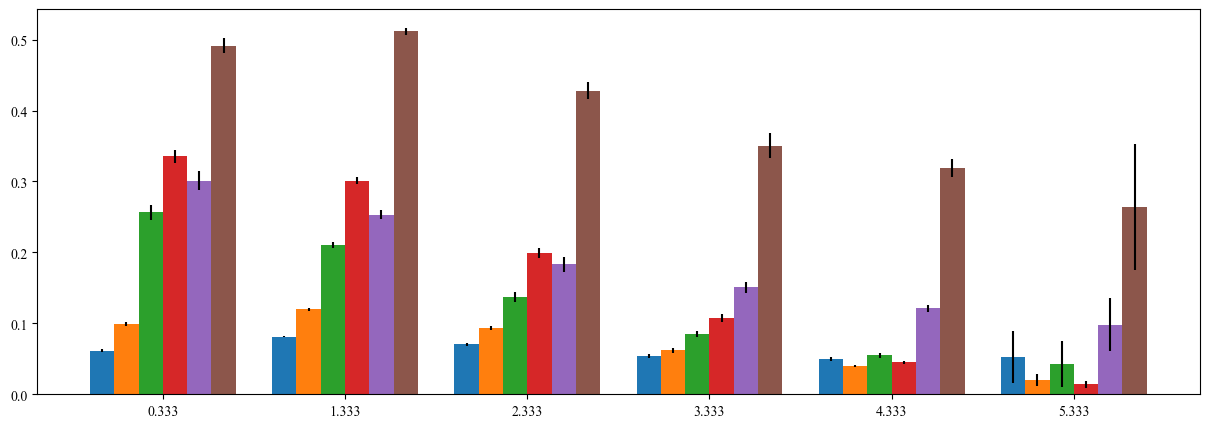

In [139]:
xticklabels = [r'$[0, 3^1)$', r'$[3^1, 3^2)$', r'$[3^2, 3^3)$', r'$[3^3, 3^4)$', r'$[3^4, 3^5)$', r'$[3^5, 3^6)$', r'$[3^6, 3^7)$', r'$[3^7, 3^8)$', r'$[3^8, 3^9)$']
file_name = './fig/' + args.dataset + '/Log_TrainDegree_TestPerformance.png'
unique_val = analyzer.log_deg_perform(keys, test_metrics, train_deg, xticklabels, args, upper_limit = 20000, base = 3, file_name = file_name)
np.unique(unique_val)

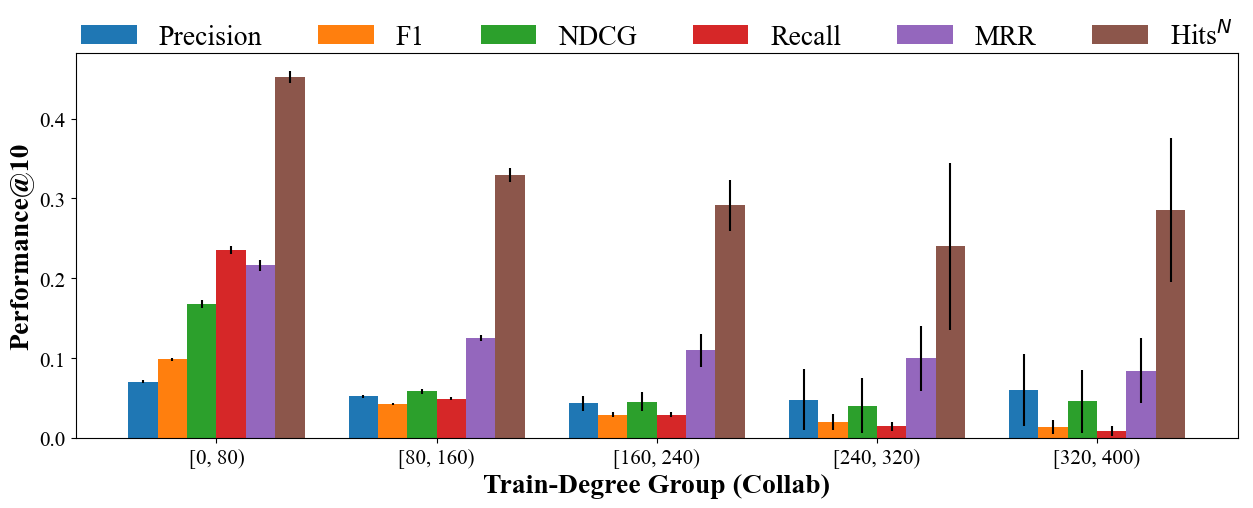

In [141]:
xticklabels = ['[0, 80)', '[80, 160)', '[160, 240)', '[240, 320)', '[320, 400)']
file_name = './fig/' + args.dataset + '/TrainDegree_TestPerformance.png'
unique_val = analyzer.deg_perform(keys, test_metrics, train_deg, xticklabels, args, group_num = 5, interval = 80, upper_limit = 400, file_name = file_name, xlabel = 'Train-Degree Group (Collab)')

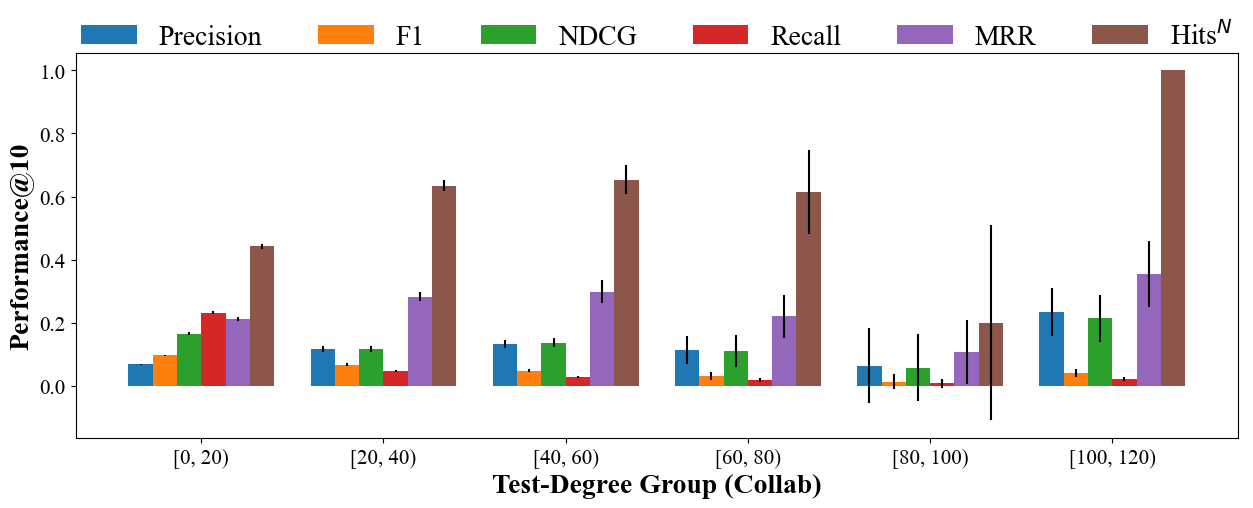

In [142]:
xticklabels = ['[0, 20)', '[20, 40)', '[40, 60)', '[60, 80)', '[80, 100)', '[100, 120)']
file_name = './fig/' + args.dataset + '/GCN_Test_Degree_Test_Performance.png'
xlabel = 'Test-Degree Group (Collab)'
analyzer.deg_perform(keys, test_metrics, test_deg, xticklabels, args, group_num = 6, interval = 20, upper_limit = math.inf, file_name = file_name, xlabel = xlabel)

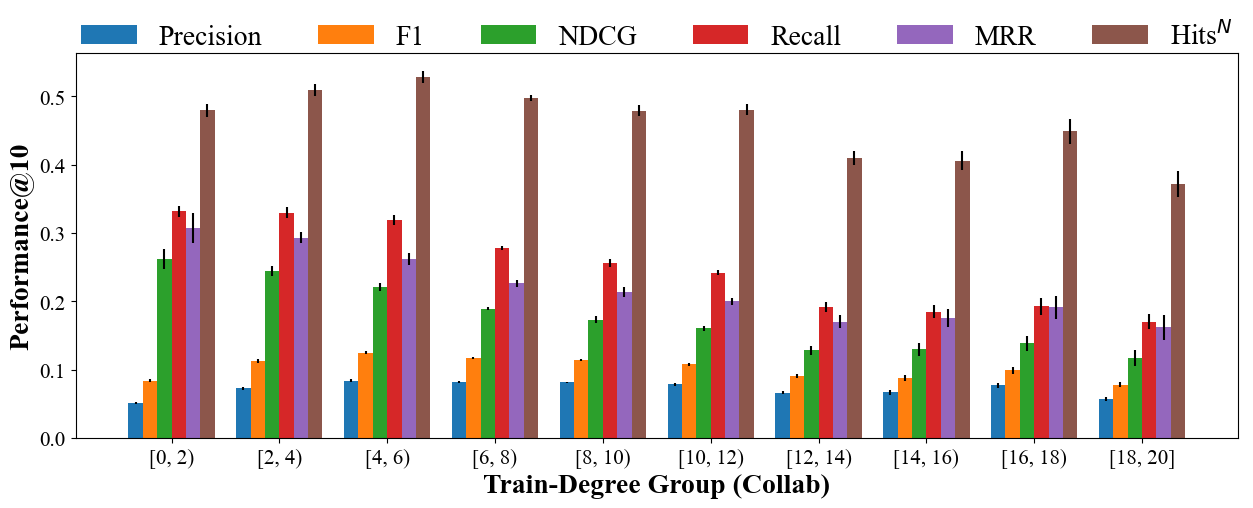

In [143]:
xticklabels = ['[0, 2)', '[2, 4)', '[4, 6)', '[6, 8)', '[8, 10)', '[10, 12)', '[12, 14)', '[14, 16)', '[16, 18)', '[18, 20]']
file_name = './fig/' + args.dataset + '/GCN_Train_Degree_TestPerformance_cold.png'
xlabel = 'Train-Degree Group (Collab)'
analyzer.deg_perform(keys, test_metrics, train_deg, xticklabels, args, group_num = 10, interval = 2, upper_limit = 20, file_name = file_name, xlabel = xlabel)

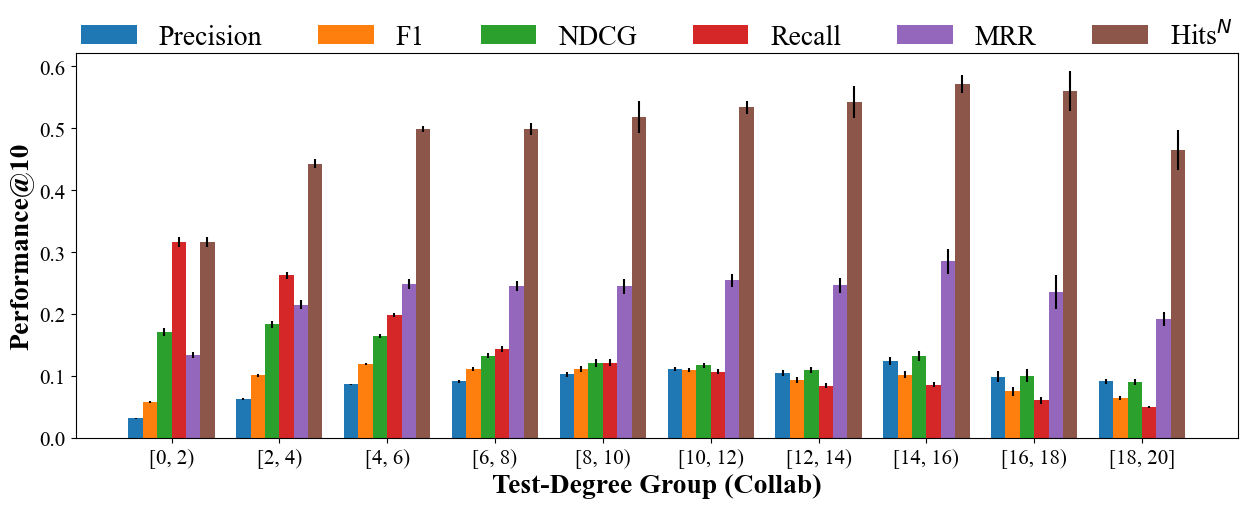

In [144]:
xticklabels = ['[0, 2)', '[2, 4)', '[4, 6)', '[6, 8)', '[8, 10)', '[10, 12)', '[12, 14)', '[14, 16)', '[16, 18)', '[18, 20]']
file_name = './fig/' + args.dataset + '/GCN_Test_Degree_TestPerformance_cold.png'
xlabel = 'Test-Degree Group (Collab)'
analyzer.deg_perform(keys, test_metrics, test_deg, xticklabels, args, group_num = 10, interval = 2, upper_limit = 20, file_name = file_name, xlabel = xlabel)

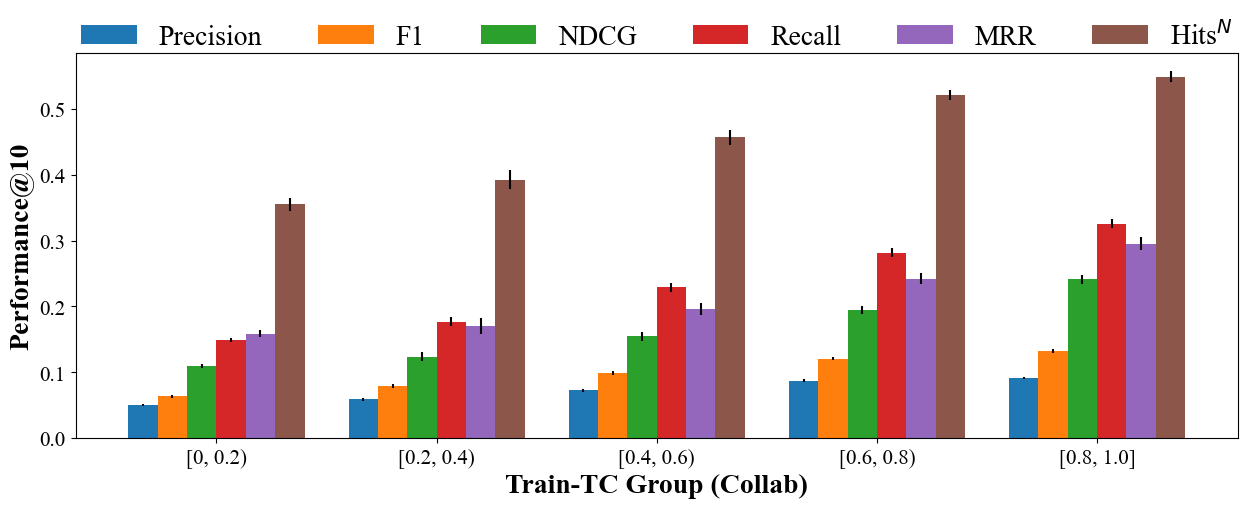

In [145]:
xticklabels = ['[0, 0.2)', '[0.2, 0.4)', '[0.4, 0.6)', '[0.6, 0.8)', '[0.8, 1.0]']
file_name = './fig/' + args.dataset + '/GCN_Train-TC_TestPerformance.png'
group_num = 5
interval = 0.2
upper_limit = 1
xlabel = 'Train-TC Group (Collab)'

analyzer.tc_perform(keys, test_metrics, tc_test_node['train'], xticklabels, args, group_num, interval, upper_limit, file_name, xlabel = xlabel)

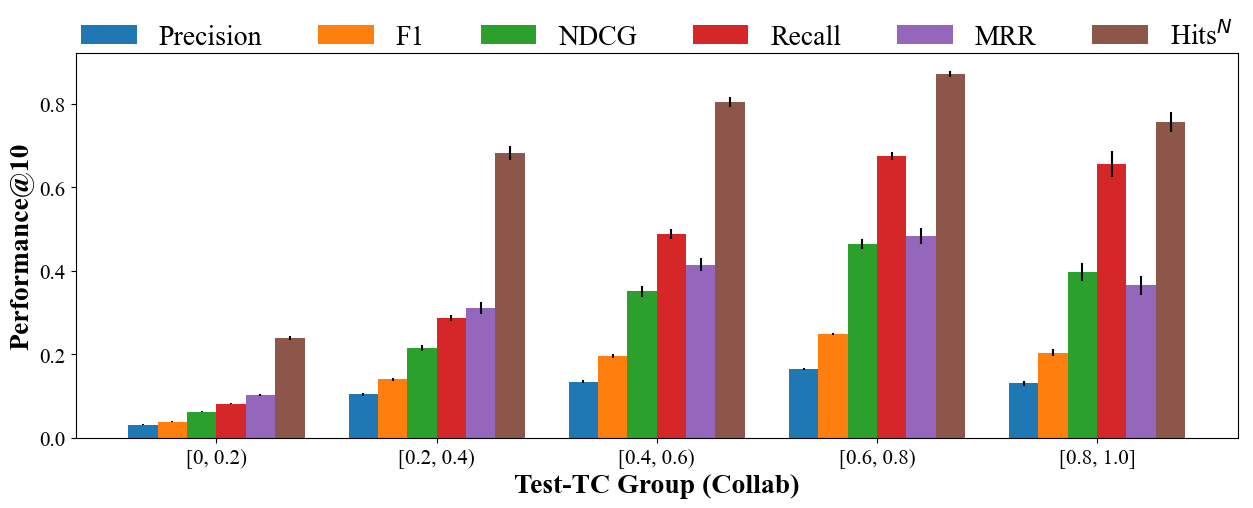

In [146]:
xticklabels = ['[0, 0.2)', '[0.2, 0.4)', '[0.4, 0.6)', '[0.6, 0.8)', '[0.8, 1.0]']
file_name = './fig/' + args.dataset + '/GCN_Test-TC_TestPerformance.png'
group_num = 5
interval = 0.2
upper_limit = 1
xlabel = 'Test-TC Group (Collab)'

analyzer.tc_perform(keys, test_metrics, tc_test_node['test'], xticklabels, args, group_num, interval, upper_limit, file_name, xlabel = xlabel)

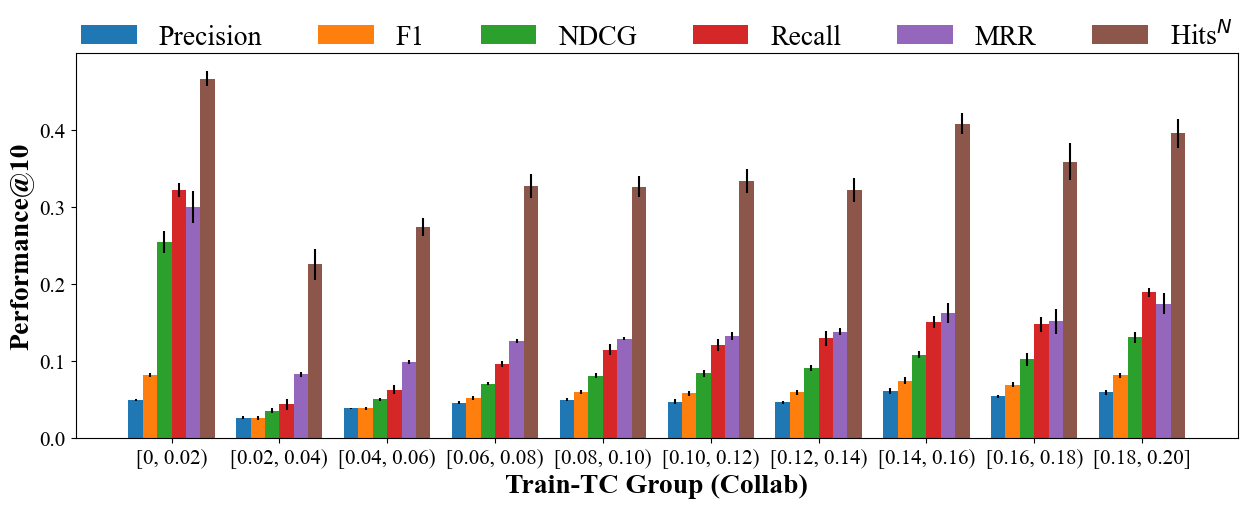

In [147]:
xticklabels = ['[0, 0.02)', '[0.02, 0.04)', '[0.04, 0.06)', '[0.06, 0.08)', '[0.08, 0.10)', '[0.10, 0.12)', '[0.12, 0.14)', '[0.14, 0.16)', '[0.16, 0.18)', '[0.18, 0.20]']
file_name = './fig/' + args.dataset + '/GCN_Train-TC_TestPerformance_cold.png'
group_num = 10
interval = 0.02
upper_limit = 0.2
xlabel = 'Train-TC Group (Collab)'

analyzer.tc_perform(keys, test_metrics, tc_test_node['train'], xticklabels, args, group_num, interval, upper_limit, file_name, xlabel = xlabel)

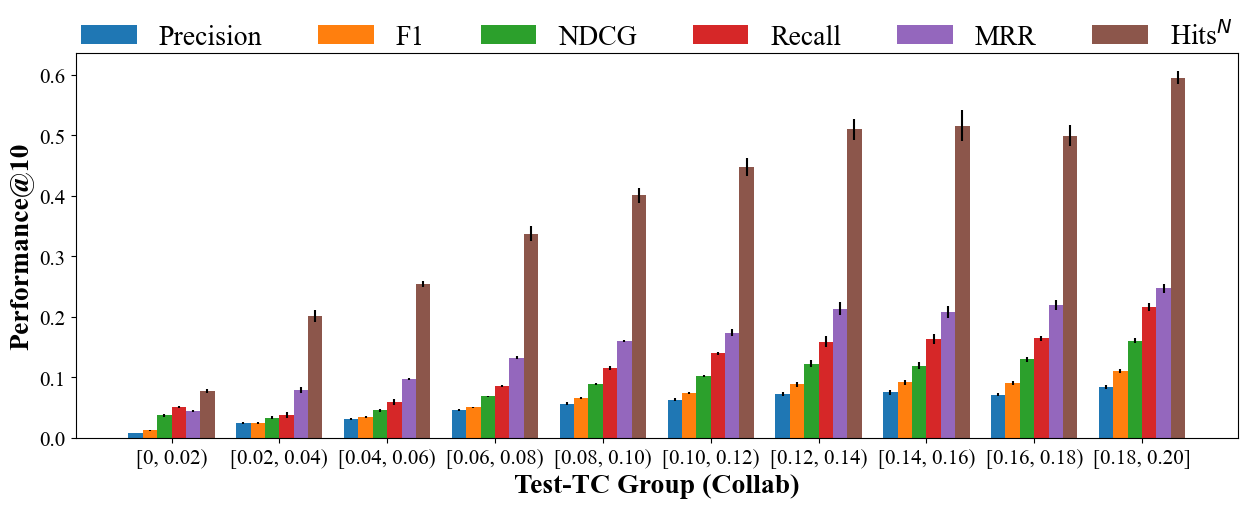

In [148]:
xticklabels = ['[0, 0.02)', '[0.02, 0.04)', '[0.04, 0.06)', '[0.06, 0.08)', '[0.08, 0.10)', '[0.10, 0.12)', '[0.12, 0.14)', '[0.14, 0.16)', '[0.16, 0.18)', '[0.18, 0.20]']
file_name = './fig/' + args.dataset + '/GCN_Test-TC_TestPerformance_cold.png'
group_num = 10
interval = 0.02
upper_limit = 0.2
xlabel = 'Test-TC Group (Collab)'

analyzer.tc_perform(keys, test_metrics, tc_test_node['test'], xticklabels, args, group_num, interval, upper_limit, file_name, xlabel = xlabel)

In [15]:
train_deg = np.array(args.deg['Train'])[test_node]
val_deg = np.array(args.deg['Val'])[test_node]
test_deg = np.array(args.deg['Test'])[test_node]
train_tc = np.array(args.tc['train_train'])[test_node]
val_tc = np.array(args.tc['train_val'])[test_node]
test_tc = np.array(args.tc['train_test'])[test_node]

In [16]:
import pickle as pkl
tc_2 = pkl.load(open('./data/ogbl-collab/tc_2.pkl', 'rb'))
tc_3 = pkl.load(open('./data/ogbl-collab/tc_3.pkl', 'rb'))

train_tc2 = np.array(tc_2['train_train'])[test_node]
val_tc2 = np.array(tc_2['train_val'])[test_node]
test_tc2 = np.array(tc_2['train_test'])[test_node]

train_tc3 = np.array(tc_3['train_train'])[test_node]
val_tc3 = np.array(tc_3['train_val'])[test_node]
test_tc3 = np.array(tc_3['train_test'])[test_node]

In [17]:
import pickle as pkl
density_1 = pkl.load(open('./data/ogbl-collab/density_1.pkl', 'rb'))
density_2 = pkl.load(open('./data/ogbl-collab/density_2.pkl', 'rb'))
density_3 = pkl.load(open('./data/ogbl-collab/density_3.pkl', 'rb'))

density1 = np.array(density_1)[test_node]
density2 = np.array(density_2)[test_node]
density3 = np.array(density_3)[test_node]

## 1. Visualize correlation between each metric and tc
### 1.1. Correlation between train-test tc and each metric

In [18]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_tc, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_tc, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_tc, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_tc, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.5241583187486988
Precision 10 0.5133039265344688
Precision 20 0.47260109763425057
Precision 50 0.3869729382243649
Precision 100 0.3054461971443119
F1 5 0.6148826203769621
F1 10 0.6084754167221287
F1 20 0.5621237068416519
F1 50 0.4520517440246686
F1 100 0.3512471954503038
NDCG 5 0.6048229449273188
NDCG 10 0.6542834817067086
NDCG 20 0.685122800350143
NDCG 50 0.7062368195493206
NDCG 100 0.7149419475813608
Recall 5 0.6212769012856909
Recall 10 0.6682500962075233
Recall 20 0.6964704999170179
Recall 50 0.7064698895803075
Recall 100 0.705620934494829
MRR 0.5327720142018798
Hits$^N$ 5 0.5349485683685344
Hits$^N$ 10 0.5485104861971875
Hits$^N$ 20 0.5510395177846951
Hits$^N$ 50 0.5289639521690508
Hits$^N$ 100 0.5026048108617073
Mean correlation: 0.5674461087263494


In [19]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_tc, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_tc, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_tc, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_tc, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.27007640388809134
Precision 10 0.2701382505453134
Precision 20 0.25373340485388235
Precision 50 0.22273175084138272
Precision 100 0.19996913364761473
F1 5 0.2649335601304952
F1 10 0.27927224418476626
F1 20 0.2717818936857051
F1 50 0.24301521501442083
F1 100 0.21794843467594083
NDCG 5 0.2396872618131464
NDCG 10 0.2506483912504499
NDCG 20 0.260238575684093
NDCG 50 0.2698576410010556
NDCG 100 0.2775679265848393
Recall 5 0.20553201809770846
Recall 10 0.2173121614920593
Recall 20 0.22386102389769003
Recall 50 0.22868571721506983
Recall 100 0.23500690491423296
MRR 0.26146322190448323
Hits$^N$ 5 0.25853646201040875
Hits$^N$ 10 0.2622114674667904
Hits$^N$ 20 0.2606642299125637
Hits$^N$ 50 0.24446813556947966
Hits$^N$ 100 0.23308777343068113
Mean correlation: 0.24701650783509094


In [20]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_tc, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_tc, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_tc, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_tc, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.20363816943315208
Precision 10 0.17165499916500238
Precision 20 0.12388454194546011
Precision 50 0.05888871063471701
Precision 100 0.014177891467144056
F1 5 0.24715379428743045
F1 10 0.21705822067981356
F1 20 0.16290868933258093
F1 50 0.08003095246139094
F1 100 0.02456243064245197
NDCG 5 0.23675066126363953
NDCG 10 0.24711026723141838
NDCG 20 0.2459863647625019
NDCG 50 0.23573234398381826
NDCG 100 0.2285814501613144
Recall 5 0.2338494245440315
Recall 10 0.22866874003638252
Recall 20 0.2113509626130448
Recall 50 0.1749927709138865
Recall 100 0.1514812063079886
MRR 0.20563113052199797
Hits$^N$ 5 0.19063544902525698
Hits$^N$ 10 0.1647537316327061
Hits$^N$ 20 0.13207274907690641
Hits$^N$ 50 0.07922566064487034
Hits$^N$ 100 0.04179026017945485
Mean correlation: 0.16586813742109088


In [21]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_deg, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_deg, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_deg, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_deg, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 -0.06737863719064477
Precision 10 -0.016174743505539223
Precision 20 0.05887479302146867
Precision 50 0.17270595490096663
Precision 100 0.2635020808266596
F1 5 -0.1637207953499199
F1 10 -0.12593749585173894
F1 20 -0.0484812458039483
F1 50 0.09865730154495812
F1 100 0.2193096778441662
NDCG 5 -0.14854859849322158
NDCG 10 -0.16528352720132808
NDCG 20 -0.16968641892621125
NDCG 50 -0.15923474849708408
NDCG 100 -0.14253497727599287
Recall 5 -0.18663433898388165
Recall 10 -0.1950702108502253
Recall 20 -0.18780247677991163
Recall 50 -0.1572827837407603
Recall 100 -0.12338391147971084
MRR -0.11312611315500741
Hits$^N$ 5 -0.08647267684896046
Hits$^N$ 10 -0.06588772927379588
Hits$^N$ 20 -0.03293705680599292
Hits$^N$ 50 0.016043141250100153
Hits$^N$ 100 0.057584522721980495
Mean correlation: -0.05649619284244521


In [22]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_deg, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_deg, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_deg, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_deg, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.04055901389214419
Precision 10 0.09423448830106938
Precision 20 0.1557997169571039
Precision 50 0.23923134265238477
Precision 100 0.3273712288567777
F1 5 -0.0786099136805064
F1 10 -0.04156211725622954
F1 20 0.021800759903608184
F1 50 0.14106572718464128
F1 100 0.2609004811360273
NDCG 5 -0.050337341690978026
NDCG 10 -0.06836105251139997
NDCG 20 -0.07845029329749675
NDCG 50 -0.0809334603317609
NDCG 100 -0.06938303241655476
Recall 5 -0.11576152506233085
Recall 10 -0.12351144090425364
Recall 20 -0.12443226649270733
Recall 50 -0.11821842572767068
Recall 100 -0.09984982241604891
MRR -0.0033396471949343866
Hits$^N$ 5 0.01563692765213396
Hits$^N$ 10 0.03713024095757045
Hits$^N$ 20 0.05767125487387686
Hits$^N$ 50 0.08036955706415744
Hits$^N$ 100 0.10527001064176494
Mean correlation: 0.020165015811168783


In [23]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_deg, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_deg, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_deg, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_deg, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.1269919798918215
Precision 10 0.21333223784788022
Precision 20 0.3168744055441569
Precision 50 0.4710226182422675
Precision 100 0.6066794867291747
F1 5 -0.0785862367146209
F1 10 -0.006009148320065668
F1 20 0.10819020315215204
F1 50 0.3214102825114625
F1 100 0.5098944340840346
NDCG 5 -0.04617609585516683
NDCG 10 -0.08007726905535277
NDCG 20 -0.09488057311130962
NDCG 50 -0.0916327183862635
NDCG 100 -0.07280120352030912
Recall 5 -0.17346422115831225
Recall 10 -0.18497068253528842
Recall 20 -0.19082034347941398
Recall 50 -0.18118809074221864
Recall 100 -0.16250554593175004
MRR 0.05218869660664161
Hits$^N$ 5 0.07634156186801068
Hits$^N$ 10 0.1067540264654254
Hits$^N$ 20 0.1368186481763378
Hits$^N$ 50 0.17326970077873888
Hits$^N$ 100 0.19031390181132088
Mean correlation: 0.07872961749612897


In [24]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(density, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(density, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(density, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(density, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.1890464047236826
Precision 10 0.14579311638356796
Precision 20 0.08472596740840789
Precision 50 0.0014505659309571215
Precision 100 -0.055048005782451566
F1 5 0.25435136934329006
F1 10 0.20783279030286375
F1 20 0.1340769849398412
F1 50 0.025640810210388037
F1 100 -0.045638347877696855
NDCG 5 0.25748870402977625
NDCG 10 0.26962247598541733
NDCG 20 0.2655319548907534
NDCG 50 0.24870328620903454
NDCG 100 0.23573099488174598
Recall 5 0.2707590755476377
Recall 10 0.26340197712968744
Recall 20 0.23875083082254078
Recall 50 0.1886163896114688
Recall 100 0.15225045402274506
MRR 0.2063168366505694
Hits$^N$ 5 0.19022472869384774
Hits$^N$ 10 0.15984817569438986
Hits$^N$ 20 0.11766331033379529
Hits$^N$ 50 0.051255012606586804
Hits$^N$ 100 0.0013806019568947006
Mean correlation: 0.15614524864037466


In [25]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(density2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(density2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(density2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(density2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.049291040075596364
Precision 10 0.023071806385455612
Precision 20 -0.016228563581708298
Precision 50 -0.07162111752482896
Precision 100 -0.11290818614274534
F1 5 0.09962792537572294
F1 10 0.06598680393722338
F1 20 0.013331042467617647
F1 50 -0.061486663575367695
F1 100 -0.11294249479997202
NDCG 5 0.09286069634714357
NDCG 10 0.10191976917818141
NDCG 20 0.09575302441412258
NDCG 50 0.07792773897590304
NDCG 100 0.061615625624152036
Recall 5 0.1324915824965173
Recall 10 0.12961057882891158
Recall 20 0.10955692021634916
Recall 50 0.06359033488401317
Recall 100 0.021480901413276028
MRR 0.027578166260414753
Hits$^N$ 5 0.04152560831468113
Hits$^N$ 10 0.02190493048118304
Hits$^N$ 20 -0.011007478861279455
Hits$^N$ 50 -0.06349954431596372
Hits$^N$ 100 -0.10722336128009564
Mean correlation: 0.025854118676711675


In [26]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(density3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(density3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(density3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(density3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.018371535556316952
Precision 10 -0.011537260522417
Precision 20 -0.04282684307862956
Precision 50 -0.07720866745243525
Precision 100 -0.09764974438590814
F1 5 0.04767424995376379
F1 10 0.010019435133407568
F1 20 -0.031301472835506036
F1 50 -0.07678163003791219
F1 100 -0.102218403860749
NDCG 5 0.04820447575032375
NDCG 10 0.04393031656214661
NDCG 20 0.03270035018714656
NDCG 50 0.01608006430374872
NDCG 100 0.00364601451979418
Recall 5 0.06824580399011203
Recall 10 0.04772659101788264
Recall 20 0.020337115979103076
Recall 50 -0.02016207959725546
Recall 100 -0.052560941755363105
MRR 0.003959198259205463
Hits$^N$ 5 0.010328560928418811
Hits$^N$ 10 -0.015124009713986692
Hits$^N$ 20 -0.046113307188917145
Hits$^N$ 50 -0.09022485045855597
Hits$^N$ 100 -0.12373503865136928
Mean correlation: -0.016008482207601333


In [27]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_tc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_tc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_tc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_tc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.22181914861476287
Precision 10 0.19957845352455078
Precision 20 0.1555702550748438
Precision 50 0.08869716277637568
Precision 100 0.035194539386590326
F1 5 0.26505766076905973
F1 10 0.24313757026041266
F1 20 0.19183744567253747
F1 50 0.10709632990128191
F1 100 0.04308153209671887
NDCG 5 0.25120971075800536
NDCG 10 0.2671132636456279
NDCG 20 0.2682127149010656
NDCG 50 0.25791711626418495
NDCG 100 0.24819211844727046
Recall 5 0.25431991403017873
Recall 10 0.2579610724929094
Recall 20 0.2446825235406044
Recall 50 0.20661919676795062
Recall 100 0.1752214269289369
MRR 0.20307938663266603
Hits$^N$ 5 0.19776657812350332
Hits$^N$ 10 0.17155715279839664
Hits$^N$ 20 0.13572385095235764
Hits$^N$ 50 0.07624601525854842
Hits$^N$ 100 0.031420398605424206
Mean correlation: 0.184550482239414


In [175]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_tc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_tc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_tc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_tc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.23159301248734152
Precision 10 0.2505862941669576
Precision 20 0.24690525726416782
Precision 50 0.21452961995357053
Precision 100 0.183230656159353
F1 5 0.2315575183856594
F1 10 0.26390031203601355
F1 20 0.2673959453912952
F1 50 0.23639965527810416
F1 100 0.1994037044920294
NDCG 5 0.2152202802763657
NDCG 10 0.23949947390393467
NDCG 20 0.25624917032705036
NDCG 50 0.2659508866154253
NDCG 100 0.2685192328897536
Recall 5 0.19654934059537196
Recall 10 0.2319770410885656
Recall 20 0.25299731167588335
Recall 50 0.2613564052438144
Recall 100 0.25829100708277897
MRR 0.22212939766668596
Hits$^N$ 5 0.23311732449736888
Hits$^N$ 10 0.2552140419326658
Hits$^N$ 20 0.2631871717774495
Hits$^N$ 50 0.2586212789936326
Hits$^N$ 100 0.248663227956485
Mean correlation: 0.24050171415914326


In [176]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_tc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_tc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_tc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_tc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.4658899234380413
Precision 10 0.48020920562489466
Precision 20 0.44697259821177115
Precision 50 0.358685233468008
Precision 100 0.281671997692473
F1 5 0.5631791038596214
F1 10 0.5805831577463344
F1 20 0.5342419438175343
F1 50 0.42061405842655125
F1 100 0.3222147857955144
NDCG 5 0.569368090628147
NDCG 10 0.6497411787176703
NDCG 20 0.6876430967080256
NDCG 50 0.7049288136872359
NDCG 100 0.7082922855766942
Recall 5 0.6187752510512271
Recall 10 0.7159529149780124
Recall 20 0.7660852684752268
Recall 50 0.7840334084064045
Recall 100 0.7782166006271055
MRR 0.4910027776360703
Hits$^N$ 5 0.5079680719099522
Hits$^N$ 10 0.5650485397540073
Hits$^N$ 20 0.5815446872854527
Hits$^N$ 50 0.5699205971864245
Hits$^N$ 100 0.5535286263466611
Mean correlation: 0.5656273929636562


In [177]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_tc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_tc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_tc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_tc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.1874794222645224
Precision 10 0.17595622950956194
Precision 20 0.14282721429211087
Precision 50 0.0912768822574831
Precision 100 0.057719283708358764
F1 5 0.22310532710204287
F1 10 0.211678251273922
F1 20 0.16735761285049233
F1 50 0.09977092174901742
F1 100 0.05787210183056125
NDCG 5 0.19982745478301234
NDCG 10 0.2207781229145929
NDCG 20 0.2186190287238958
NDCG 50 0.20425619728650513
NDCG 100 0.19326399266163913
Recall 5 0.21937910761127807
Recall 10 0.2342479695957154
Recall 20 0.21798558564418952
Recall 50 0.17878710849192261
Recall 100 0.14624390076095425
MRR 0.15611266228231402
Hits$^N$ 5 0.17126162438477985
Hits$^N$ 10 0.15588554332338012
Hits$^N$ 20 0.1136493183924544
Hits$^N$ 50 0.05416933964066337
Hits$^N$ 100 0.01608198884292177
Mean correlation: 0.15829200739147276


In [178]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_tc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_tc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_tc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_tc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.22282740965041764
Precision 10 0.24580593940307735
Precision 20 0.24764707728488974
Precision 50 0.22452320140346158
Precision 100 0.20005185469296907
F1 5 0.22027250204292206
F1 10 0.25465218984925997
F1 20 0.26198643232905555
F1 50 0.24057911682854471
F1 100 0.21176408674349145
NDCG 5 0.20577314239643937
NDCG 10 0.23013682998172785
NDCG 20 0.2464320210449965
NDCG 50 0.2566043319285674
NDCG 100 0.2598125445835532
Recall 5 0.1882772334022453
Recall 10 0.22416995673050613
Recall 20 0.24432423564171118
Recall 50 0.25322414994849046
Recall 100 0.25061584090940686
MRR 0.20846772593640828
Hits$^N$ 5 0.2208653629472186
Hits$^N$ 10 0.24268779209714783
Hits$^N$ 20 0.2503419256374507
Hits$^N$ 50 0.24632649734236098
Hits$^N$ 100 0.23688821394399967
Mean correlation: 0.23442529287308922


In [179]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_tc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_tc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_tc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_tc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.431623125689993
Precision 10 0.4544920287252469
Precision 20 0.4328146121213714
Precision 50 0.36123949893658525
Precision 100 0.29536109156282414
F1 5 0.5177672176388968
F1 10 0.5421424387931436
F1 20 0.5071166686476049
F1 50 0.4131929387217055
F1 100 0.3295110855931367
NDCG 5 0.5238475163994751
NDCG 10 0.6012575653553389
NDCG 20 0.6375356955521987
NDCG 50 0.6546124618895081
NDCG 100 0.6588095978771592
Recall 5 0.5718494709042754
Recall 10 0.6677877452154787
Recall 20 0.7150155512371572
Recall 50 0.7311611999465322
Recall 100 0.7260353537514489
MRR 0.45005946529792074
Hits$^N$ 5 0.46853309318854447
Hits$^N$ 10 0.5257197397305766
Hits$^N$ 20 0.5407521175661573
Hits$^N$ 50 0.5293288540491451
Hits$^N$ 100 0.514457119501351
Mean correlation: 0.5308470482266453


In [16]:
import pickle as pkl

atc_1 = pkl.load(open('./data/ogbl-collab/appro_tc_1.pkl', 'rb'))
atc_2 = pkl.load(open('./data/ogbl-collab/appro_tc_2.pkl', 'rb'))
atc_3 = pkl.load(open('./data/ogbl-collab/appro_tc_3.pkl', 'rb'))
atc_4 = pkl.load(open('./data/ogbl-collab/appro_tc_4.pkl', 'rb'))
atc_5 = pkl.load(open('./data/ogbl-collab/appro_tc_5.pkl', 'rb'))

train_atc1 = np.array(atc_1['train_train'])[test_node]
val_atc1 = np.array(atc_1['train_val'])[test_node]
test_atc1 = np.array(atc_1['train_test'])[test_node]

train_atc2 = np.array(atc_2['train_train'])[test_node]
val_atc2 = np.array(atc_2['train_val'])[test_node]
test_atc2 = np.array(atc_2['train_test'])[test_node]

train_atc3 = np.array(atc_3['train_train'])[test_node]
val_atc3 = np.array(atc_3['train_val'])[test_node]
test_atc3 = np.array(atc_3['train_test'])[test_node]

train_atc4 = np.array(atc_4['train_train'])[test_node]
val_atc4 = np.array(atc_4['train_val'])[test_node]
test_atc4 = np.array(atc_4['train_test'])[test_node]

train_atc5 = np.array(atc_5['train_train'])[test_node]
val_atc5 = np.array(atc_5['train_val'])[test_node]
test_atc5 = np.array(atc_5['train_test'])[test_node]

In [39]:
import pickle as pkl

atc_1 = pkl.load(open('./data/ogbl-collab/appro_tc_dot_1.pkl', 'rb'))
atc_2 = pkl.load(open('./data/ogbl-collab/appro_tc_dot_2.pkl', 'rb'))
atc_3 = pkl.load(open('./data/ogbl-collab/appro_tc_dot_3.pkl', 'rb'))
atc_4 = pkl.load(open('./data/ogbl-collab/appro_tc_dot_4.pkl', 'rb'))
atc_5 = pkl.load(open('./data/ogbl-collab/appro_tc_dot_5.pkl', 'rb'))

train_atc1 = np.array(atc_1['train_train'])[test_node]
val_atc1 = np.array(atc_1['train_val'])[test_node]
test_atc1 = np.array(atc_1['train_test'])[test_node]

train_atc2 = np.array(atc_2['train_train'])[test_node]
val_atc2 = np.array(atc_2['train_val'])[test_node]
test_atc2 = np.array(atc_2['train_test'])[test_node]

train_atc3 = np.array(atc_3['train_train'])[test_node]
val_atc3 = np.array(atc_3['train_val'])[test_node]
test_atc3 = np.array(atc_3['train_test'])[test_node]

train_atc4 = np.array(atc_4['train_train'])[test_node]
val_atc4 = np.array(atc_4['train_val'])[test_node]
test_atc4 = np.array(atc_4['train_test'])[test_node]

train_atc5 = np.array(atc_5['train_train'])[test_node]
val_atc5 = np.array(atc_5['train_val'])[test_node]
test_atc5 = np.array(atc_5['train_test'])[test_node]

In [40]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_atc1, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_atc1, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_atc1, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_atc1, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.07300582246764747
Precision 10 0.0322873562659376
Precision 20 -0.023968840067612088
Precision 50 -0.10470444075364052
Precision 100 -0.15774850377315008
F1 5 0.14515041288841019
F1 10 0.09527041001228931
F1 20 0.022507700607740645
F1 50 -0.08380473510858523
F1 100 -0.1525254875866864
NDCG 5 0.15530805154754004
NDCG 10 0.16545658620056214
NDCG 20 0.15816466825263698
NDCG 50 0.1365531558947846
NDCG 100 0.11800877228845132
Recall 5 0.18862732459585185
Recall 10 0.1800721134626267
Recall 20 0.1544831180215447
Recall 50 0.10056598118001309
Recall 100 0.053979328308684606
MRR 0.09149932201684023
Hits$^N$ 5 0.08523376185192282
Hits$^N$ 10 0.05802129185938239
Hits$^N$ 20 0.017798484933586906
Hits$^N$ 50 -0.04839967976123398
Hits$^N$ 100 -0.09875276225507905
Mean correlation: 0.052388046667325626


In [28]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_atc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_atc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_atc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_atc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.24456068086976018
Precision 10 0.2183212149787214
Precision 20 0.17011327572549684
Precision 50 0.09152240518308231
Precision 100 0.02302311743286688
F1 5 0.29620262496970606
F1 10 0.2714975012232678
F1 20 0.21557209678732148
F1 50 0.1161526838779536
F1 100 0.034007930315497314
NDCG 5 0.2911734940235235
NDCG 10 0.30995511766378897
NDCG 20 0.3135401063426576
NDCG 50 0.30292288185074356
NDCG 100 0.28957941565653983
Recall 5 0.2943934530945879
Recall 10 0.3033531148295789
Recall 20 0.2936046462189762
Recall 50 0.2526969732435093
Recall 100 0.21087851436726437
MRR 0.24104491227465719
Hits$^N$ 5 0.23239456535680603
Hits$^N$ 10 0.2021666320799295
Hits$^N$ 20 0.15956200258920003
Hits$^N$ 50 0.08234043397782673
Hits$^N$ 100 0.02006031759524687
Mean correlation: 0.21079385048186577


In [19]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_atc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_atc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_atc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_atc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.25693878576201845
Precision 10 0.23041030607814775
Precision 20 0.18156849048667253
Precision 50 0.10097092273122371
Precision 100 0.030223355537980275
F1 5 0.30970691671489864
F1 10 0.2853353548574099
F1 20 0.2290434689230953
F1 50 0.12725573435045104
F1 100 0.04237035246735975
NDCG 5 0.30440582978932834
NDCG 10 0.3241153777264218
NDCG 20 0.3286868140912321
NDCG 50 0.3187699879980562
NDCG 100 0.30562521167333345
Recall 5 0.30712390680397583
Recall 10 0.31747609470142885
Recall 20 0.3092050007056918
Recall 50 0.269180082505845
Recall 100 0.2274848027803909
MRR 0.2536298125275293
Hits$^N$ 5 0.24505990567586522
Hits$^N$ 10 0.21515528186086694
Hits$^N$ 20 0.17234790850948098
Hits$^N$ 50 0.09373937599654601
Hits$^N$ 100 0.02971420877810291
Mean correlation: 0.2236747419243597


In [20]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_atc4, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_atc4, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_atc4, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_atc4, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.2658237593667362
Precision 10 0.23914127151103765
Precision 20 0.19000060850999972
Precision 50 0.10821634554392455
Precision 100 0.03601373101496752
F1 5 0.3193177027226162
F1 10 0.2952265638929953
F1 20 0.23884610264610842
F1 50 0.13565680570305058
F1 100 0.04899307088094147
NDCG 5 0.31398818907110226
NDCG 10 0.3343350634705713
NDCG 20 0.3396479261076373
NDCG 50 0.33032662557723075
NDCG 100 0.31737944708919036
Recall 5 0.31628450054534973
Recall 10 0.32762925014357175
Recall 20 0.3205194607372158
Recall 50 0.28133263065932335
Recall 100 0.23982264785546323
MRR 0.2627360392836741
Hits$^N$ 5 0.25425965177895266
Hits$^N$ 10 0.22463217244612088
Hits$^N$ 20 0.18176720718717349
Hits$^N$ 50 0.1022809236432818
Hits$^N$ 100 0.03702186225537754
Mean correlation: 0.23312305998629285


In [21]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(train_atc5, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(train_atc5, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(train_atc5, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(train_atc5, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.2722813856306774
Precision 10 0.245715095951377
Precision 20 0.19668653098271774
Precision 50 0.11444659108152921
Precision 100 0.04140753960529309
F1 5 0.32600686026298964
F1 10 0.30237413262189794
F1 20 0.24633187345934499
F1 50 0.14264220220704169
F1 100 0.05497398083315439
NDCG 5 0.32065676270306975
NDCG 10 0.3414568028028077
NDCG 20 0.34738634897770515
NDCG 50 0.3386357039356286
NDCG 100 0.3259166367103206
Recall 5 0.3224956315503351
Recall 10 0.33463673491887097
Recall 20 0.32857115453034164
Recall 50 0.29028837944915115
Recall 100 0.2490761329168064
MRR 0.26925399005967243
Hits$^N$ 5 0.26095553542646166
Hits$^N$ 10 0.23160315653343672
Hits$^N$ 20 0.1888597336171681
Hits$^N$ 50 0.10889725681241406
Hits$^N$ 100 0.04279014966896849
Mean correlation: 0.24016716550958395


In [29]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_atc1, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_atc1, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_atc1, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_atc1, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.1992499666457123
Precision 10 0.22448760041713017
Precision 20 0.23243542305823764
Precision 50 0.22352224725227102
Precision 100 0.2110805097038531
F1 5 0.1817684698100129
F1 10 0.21905909017712122
F1 20 0.2376818199046983
F1 50 0.23643152059148545
F1 100 0.22509848610970437
NDCG 5 0.15199315841172012
NDCG 10 0.16738473697357706
NDCG 20 0.18178181537527877
NDCG 50 0.19598900829884655
NDCG 100 0.20543644589325544
Recall 5 0.1314008330812748
Recall 10 0.15741722106082273
Recall 20 0.178153406560279
Recall 50 0.19640489512923584
Recall 100 0.2088970972315245
MRR 0.16807191514707953
Hits$^N$ 5 0.18021764942766075
Hits$^N$ 10 0.19769369286299468
Hits$^N$ 20 0.2114788322734977
Hits$^N$ 50 0.20903296851660286
Hits$^N$ 100 0.21107565618252996
Mean correlation: 0.19781709484986182


In [30]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_atc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_atc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_atc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_atc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.2015035900802717
Precision 10 0.22368803350453062
Precision 20 0.2327630241669399
Precision 50 0.2289563032804067
Precision 100 0.21937630355672705
F1 5 0.1832333307825141
F1 10 0.2177968333447626
F1 20 0.23798173843727138
F1 50 0.24275901979708348
F1 100 0.23475395361308768
NDCG 5 0.15942304508511593
NDCG 10 0.17256098153955016
NDCG 20 0.18696915402383366
NDCG 50 0.20317628357303197
NDCG 100 0.2140721845394885
Recall 5 0.134710773964194
Recall 10 0.15790960266882756
Recall 20 0.1790162981767785
Recall 50 0.20120602607286237
Recall 100 0.2165780071494803
MRR 0.1794061807609872
Hits$^N$ 5 0.18874664846592132
Hits$^N$ 10 0.2074392207628951
Hits$^N$ 20 0.22360633541264532
Hits$^N$ 50 0.22606390597744597
Hits$^N$ 100 0.23108188684073916
Mean correlation: 0.20402994867605354


In [31]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_atc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_atc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_atc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_atc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.20345676149857972
Precision 10 0.225330001839531
Precision 20 0.23491341886356729
Precision 50 0.2322065949344792
Precision 100 0.22340170688313776
F1 5 0.18428524879413327
F1 10 0.21881776136329104
F1 20 0.23981711677248196
F1 50 0.24600935976646873
F1 100 0.2389744956293522
NDCG 5 0.1612999003141376
NDCG 10 0.1739476404884996
NDCG 20 0.1884683199916602
NDCG 50 0.20506840109685823
NDCG 100 0.21635529537916126
Recall 5 0.13514871493474387
Recall 10 0.15798241978554706
Recall 20 0.179411015433159
Recall 50 0.20219571410856985
Recall 100 0.21832118373720458
MRR 0.18269495126248667
Hits$^N$ 5 0.1913363081094963
Hits$^N$ 10 0.2101887568230081
Hits$^N$ 20 0.22684197666142472
Hits$^N$ 50 0.2297541219892476
Hits$^N$ 100 0.23503554084044867
Mean correlation: 0.20620241258848754


In [32]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_atc4, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_atc4, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_atc4, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_atc4, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.20491353834374856
Precision 10 0.22650710209117839
Precision 20 0.2364296295930088
Precision 50 0.2346015735704704
Precision 100 0.22644010500548498
F1 5 0.185051477851909
F1 10 0.2194880667908587
F1 20 0.24104093832591567
F1 50 0.2483447088592372
F1 100 0.24210793228618585
NDCG 5 0.1627721224085407
NDCG 10 0.1750227337753219
NDCG 20 0.18959282688359766
NDCG 50 0.20647340856773302
NDCG 100 0.2180466945479289
Recall 5 0.1354800618700682
Recall 10 0.1579777244225842
Recall 20 0.1795909450567219
Recall 50 0.20280089690149258
Recall 100 0.21946403409800233
MRR 0.1852153110586364
Hits$^N$ 5 0.19329676975637156
Hits$^N$ 10 0.21221509568556673
Hits$^N$ 20 0.2291619995928157
Hits$^N$ 50 0.2323972151740324
Hits$^N$ 100 0.23780838808700538
Mean correlation: 0.20777851156170835


In [33]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(val_atc5, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(val_atc5, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(val_atc5, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(val_atc5, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.2060820156126061
Precision 10 0.22750640757794505
Precision 20 0.2377111077132503
Precision 50 0.2366300702730283
Precision 100 0.22902254730058932
F1 5 0.18563713770423224
F1 10 0.22002919349580546
F1 20 0.2420328632893796
F1 50 0.25027933853616063
F1 100 0.24473019909864788
NDCG 5 0.1639025439342115
NDCG 10 0.17584780583017162
NDCG 20 0.19044595659085511
NDCG 50 0.20754935096343313
NDCG 100 0.21935172462722372
Recall 5 0.1356868480618347
Recall 10 0.15791049156094586
Recall 20 0.17964456166544618
Recall 50 0.20319426607881974
Recall 100 0.2202814495752849
MRR 0.18718328158597097
Hits$^N$ 5 0.19485356330696563
Hits$^N$ 10 0.21380790740852842
Hits$^N$ 20 0.23095676656158104
Hits$^N$ 50 0.2344164349074079
Hits$^N$ 100 0.23989091643213134
Mean correlation: 0.20902249037278683


In [34]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_atc1, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_atc1, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_atc1, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_atc1, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.386527805279995
Precision 10 0.41411852820542366
Precision 20 0.41223332935109697
Precision 50 0.36597499238549364
Precision 100 0.30147122066759147
F1 5 0.4474477335476246
F1 10 0.4844265211905923
F1 20 0.4827317492822351
F1 50 0.4206526665963414
F1 100 0.3417474424338891
NDCG 5 0.40615184389523196
NDCG 10 0.46320199804244866
NDCG 20 0.5042640337752937
NDCG 50 0.5359812481412978
NDCG 100 0.5482868869423441
Recall 5 0.4445502484553427
Recall 10 0.5237136048988231
Recall 20 0.5855068992996189
Recall 50 0.6314746667552144
Recall 100 0.6476985577393364
MRR 0.3489760887123544
Hits$^N$ 5 0.37995860546130183
Hits$^N$ 10 0.41046772470322823
Hits$^N$ 20 0.43779015438400737
Hits$^N$ 50 0.44734772168134185
Hits$^N$ 100 0.4440086476104051
Mean correlation: 0.45448888151684125


In [35]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_atc2, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_atc2, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_atc2, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_atc2, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.42090666925774006
Precision 10 0.4393791568714133
Precision 20 0.4323018314954568
Precision 50 0.38112893316346574
Precision 100 0.3140664145578128
F1 5 0.4980810563734288
F1 10 0.5220408542302145
F1 20 0.5120714917874597
F1 50 0.4417422776098396
F1 100 0.35830276592990007
NDCG 5 0.47585615507506973
NDCG 10 0.5338099207164038
NDCG 20 0.5763733113225916
NDCG 50 0.6104727665963833
NDCG 100 0.6247259003388773
Recall 5 0.5160813905712359
Recall 10 0.5910832908218087
Recall 20 0.6540411795294805
Recall 50 0.703678582667411
Recall 100 0.7235353596971649
MRR 0.40326586400583103
Hits$^N$ 5 0.42675796265006594
Hits$^N$ 10 0.45871786473109627
Hits$^N$ 20 0.48943280639071546
Hits$^N$ 50 0.5028741847266281
Hits$^N$ 100 0.5010444271292079
Mean correlation: 0.5042989391633348


In [36]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_atc3, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_atc3, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_atc3, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_atc3, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.4291578242522984
Precision 10 0.4465942927641241
Precision 20 0.4394228452104823
Precision 50 0.38906377915632756
Precision 100 0.3227826647152799
F1 5 0.5070390030233535
F1 10 0.5300386038318701
F1 20 0.5200600879248496
F1 50 0.4503821375505289
F1 100 0.36770381638098465
NDCG 5 0.486851406138237
NDCG 10 0.544705999250161
NDCG 20 0.5877461721638557
NDCG 50 0.6227349903819022
NDCG 100 0.6378467450132385
Recall 5 0.5254270310213781
Recall 10 0.6000031573316669
Recall 20 0.6636786714191538
Recall 50 0.7147794580903744
Recall 100 0.7364053349690032
MRR 0.41412771396437037
Hits$^N$ 5 0.4359741537183525
Hits$^N$ 10 0.46827214538036754
Hits$^N$ 20 0.49967358691125324
Hits$^N$ 50 0.51391338714957
Hits$^N$ 100 0.5122210830980736
Mean correlation: 0.5141002342619637


In [37]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_atc4, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_atc4, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_atc4, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_atc4, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.43518645167067216
Precision 10 0.45176845578516334
Precision 20 0.4445328575563382
Precision 50 0.39502792704242484
Precision 100 0.3295287775616377
F1 5 0.5134109321512093
F1 10 0.5356090019112446
F1 20 0.5256395876939584
F1 50 0.4567415784843064
F1 100 0.3748788887860112
NDCG 5 0.494805687109615
NDCG 10 0.5524567623160054
NDCG 20 0.5957721337031512
NDCG 50 0.6314310219366236
NDCG 100 0.6471959000016587
Recall 5 0.5319336045964699
Recall 10 0.606000858221676
Recall 20 0.6700877345945027
Recall 50 0.7223109641722102
Recall 100 0.7452576136521398
MRR 0.4221882902146176
Hits$^N$ 5 0.4427529329334134
Hits$^N$ 10 0.47517313846424597
Hits$^N$ 20 0.5069872771062692
Hits$^N$ 50 0.521821482976267
Hits$^N$ 100 0.5202146057285408
Mean correlation: 0.5211044025527066


In [38]:
count = []
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        for k in range(metric.shape[2]):
            print(key, args.topks[k], np.corrcoef(test_atc5, metric.mean(axis = 0)[:, k])[0, 1])
            count.append(np.corrcoef(test_atc5, metric.mean(axis = 0)[:, k])[0, 1])
    else:
        print(key, np.corrcoef(test_atc5, metric.mean(axis = 0))[0, 1])
        count.append(np.corrcoef(test_atc5, metric.mean(axis = 0))[0, 1])

print('Mean correlation:', np.mean(count))

Precision 5 0.4399341976731374
Precision 10 0.45591743992830713
Precision 20 0.4487171103932116
Precision 50 0.4001146485056687
Precision 100 0.33535391618596105
F1 5 0.5182193692131828
F1 10 0.5398864874346209
F1 20 0.5300482433627857
F1 50 0.46205708397723344
F1 100 0.38100146217479597
NDCG 5 0.5007701651029113
NDCG 10 0.5582183951740028
NDCG 20 0.6017307330367011
NDCG 50 0.6379635502877017
NDCG 100 0.6542664749761588
Recall 5 0.5365859221135266
Recall 10 0.6102151662120769
Recall 20 0.674601964315421
Recall 50 0.7278136132925481
Recall 100 0.7518323953502577
MRR 0.4284974610327071
Hits$^N$ 5 0.4480824649908949
Hits$^N$ 10 0.48053914291991257
Hits$^N$ 20 0.5126286434934771
Hits$^N$ 50 0.5279502917566752
Hits$^N$ 100 0.5263997870559061
Mean correlation: 0.526513312690761


In [271]:
res = {
    "Train-TC": {
        "Precision": [0.2252, 0.1925, 0.1353, 0.0578],
        "F1": [0.2601, 0.2364, 0.1733, 0.0790],
        "NDCG": [0.2279, 0.2427, 0.2375, 0.2206],
        "Recall": [0.2296, 0.2358, 0.2156, 0.1754],
        "Hits^N": [0.2057, 0.1800, 0.1328, 0.0717],
        "MRR": [0.2044, 0.2044, 0.2044, 0.2044],
    },
    "Val-TC": {
        "Precision": [0.2573, 0.2832, 0.2788, 0.2387],
        "F1": [0.2425, 0.2901, 0.2991, 0.2641],
        "NDCG": [0.2066, 0.2330, 0.2521, 0.2624],
        "Recall": [0.1742, 0.2179, 0.2428, 0.2514],
        "Hits^N": [0.2445, 0.2674, 0.2720, 0.2620],
        "MRR": [0.2350, 0.2350, 0.2350, 0.2350],
    },
    "Test-TC": {
        "Precision": [0.5184, 0.5437, 0.5107, 0.4127],
        "F1": [0.5858, 0.6311, 0.5964, 0.4799],
        "NDCG": [0.5443, 0.6282, 0.6706, 0.6902],
        "Recall": [0.5644, 0.6753, 0.7324, 0.7533],
        "Hits^N": [0.5272, 0.5816, 0.5924, 0.5720],
        "MRR": [0.5085, 0.5085, 0.5085, 0.5085],
    },
    "Train Degree": {
        "Precision": [-0.1261, -0.0829, 0.0006, 0.1440],
        "F1": [-0.1997, -0.1663, -0.0813, 0.0812],
        "NDCG": [-0.1822, -0.2017, -0.1985, -0.1750],
        "Recall": [-0.2183, -0.2288, -0.2118, -0.1681],
        "Hits^N": [-0.1395, -0.1164, -0.0658, 0.0055],
        "MRR": [-0.1349, -0.1349, -0.1349, -0.1349],
    },
    "Val Degree": {
        "Precision": [0.0047, 0.0472, 0.1117, 0.2141],
        "F1": [-0.0823, -0.0469, 0.0200, 0.1416],
        "NDCG": [-0.0608, -0.0803, -0.0838, -0.0736],
        "Recall": [-0.1203, -0.1296, -0.1269, -0.1100],
        "Hits^N": [-0.0063, 0.0171, 0.0481, 0.0848],
        "MRR": [-0.0108, -0.0108, -0.0108, -0.0108],
    },
    "Test Degree": {
        "Precision": [0.1075, 0.1833, 0.2924, 0.4617],
        "F1": [-0.0669, 0.0043, 0.1249, 0.3375],
        "NDCG": [-0.0340, -0.0723, -0.0814, -0.0668],
        "Recall": [-0.1678, -0.1856, -0.1870, -0.1724],
        "Hits^N": [0.0785, 0.1103, 0.1407, 0.1718],
        "MRR": [0.0727, 0.0727, 0.0727, 0.0727],
    },
    "Density": {
        "Precision": [0.2199, 0.1646, 0.0875, -0.0073],
        "F1": [0.2806, 0.2259, 0.1353, 0.0161],
        "NDCG": [0.2811, 0.2891, 0.2748, 0.2491],
        "Recall": [0.2911, 0.2783, 0.2399, 0.1834],
        "Hits^N": [0.2265, 0.1842, 0.1196, 0.0423],
        "MRR": [0.2331, 0.2331, 0.2331, 0.2331],
    },
}

In [274]:
def cal_abs_avg(vals):
    return sum([abs(v) for v in vals]) / len(vals)

def cal_avg(vals):
    return sum(vals) / len(vals)

topo_res = {}
for topo_metric in res:
    abs_avgs = []
    avgs = []
    for eval_metric in res[topo_metric]:
        vals = [k for k in res[topo_metric][eval_metric]]
        
        abs_avg = cal_abs_avg(vals)
        avg = cal_avg(vals)

        # print(topo_metric, eval_metric, abs_avg, avg)

        abs_avgs.append(abs_avg)
        avgs.append(abs_avg)

    topo_res[topo_metric] = [abs_avgs, avgs]

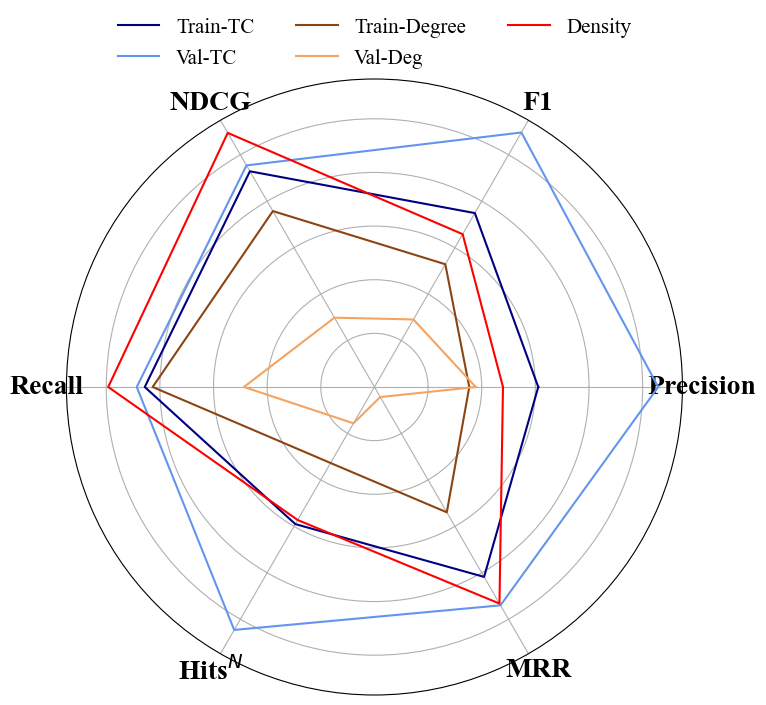

In [275]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
labels = ['Precision', 'F1', 'NDCG', 'Recall', r'Hits$^N$', 'MRR']

# Setup plot
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by adding the first angle at the end of the list
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Helper function to plot data on radar chart
def add_to_radar(angles, data, label_name, color):
    data += data[:1]  # Add the first data point at the end to close the loop
    # ax.fill(angles, data, color=color, alpha=0.25)
    ax.plot(angles, data, label=label_name, color=color)

# Plot each data series
add_to_radar(angles, topo_res['Train-TC'][1], 'Train-TC', 'navy')
add_to_radar(angles, topo_res['Val-TC'][1], 'Val-TC', 'cornflowerblue')
add_to_radar(angles, topo_res['Train Degree'][1], 'Train-Degree', 'saddlebrown')
add_to_radar(angles, topo_res['Val Degree'][1], 'Val-Deg', 'sandybrown')
add_to_radar(angles, topo_res['Density'][1], 'Density', 'red')

# Add labels to plot
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize = 20, fontweight = 'bold')

# Add legend
# ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize = 15, frameon = 0)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon = 0, fontsize = 15)

# Show plot
plt.savefig(f'./fig/{args.dataset}/Radar_correlation_part.png', transparent = True, dpi = 200, bbox_inches = 'tight')

In [16]:
train_deg = np.array(args.deg['Train'])[test_node]
val_deg = np.array(args.deg['Val'])[test_node]
test_deg = np.array(args.deg['Test'])[test_node]
train_tc = np.array(args.tc['train_train'])[test_node]
val_tc = np.array(args.tc['train_val'])[test_node]
test_tc = np.array(args.tc['train_test'])[test_node]

In [17]:
np.arange(0, 11, 1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

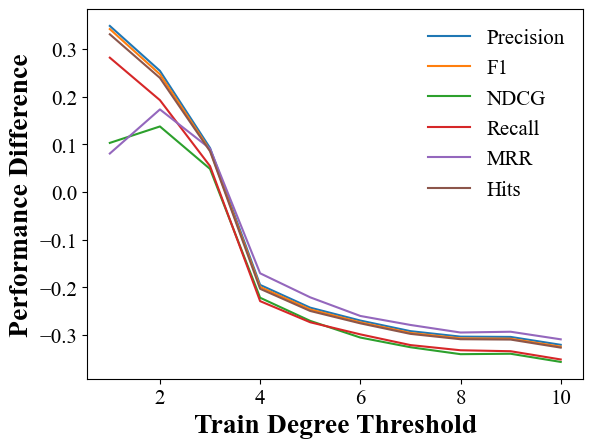

In [52]:
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        ratio = []
        
        for k in range(metric.shape[2]):
            ratio.append([])
            tmp = metric.mean(axis = 0)[:, k]
            for interval in np.arange(1, 11, 1):
                val1 = tmp[train_deg <= interval].mean()
                val2 = tmp[train_deg > interval] .mean()
                ratio[-1].append((val2 - val1)/val1)

        # print(np.array(ratio).mean(axis = 0))
        plt.plot(range(1, 11, 1), np.array(ratio).mean(axis = 0), label = key)
    else:
        ratio = []

        tmp = metric.mean(axis = 0)
        for interval in np.arange(1, 11, 1):
            val1 = tmp[train_deg <= interval].mean()
            val2 = tmp[train_deg > interval] .mean()
            ratio.append((val2 - val1)/val1)

        plt.plot(range(1, 11, 1), np.array(ratio), label = key)
    
        
plt.xlabel('Train Degree Threshold', fontsize = 20, fontweight = 'bold')
plt.ylabel('Performance Difference', fontsize = 20, fontweight = 'bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.legend(frameon = 0, fontsize = 15)

(array([0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

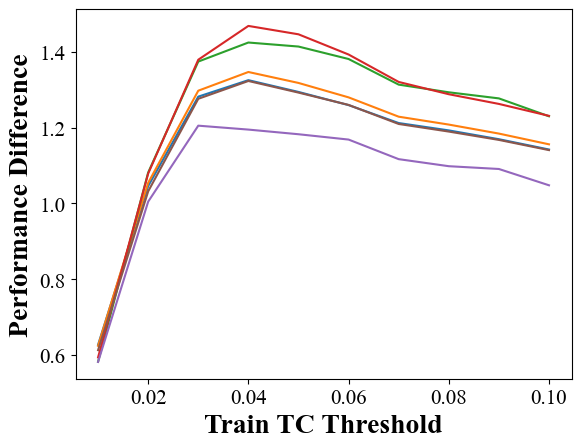

In [57]:
for key, metric in zip(keys, test_metrics):
    if key not in ['MRR']:
        ratio = []
        
        for k in range(metric.shape[2]):
            ratio.append([])
            tmp = metric.mean(axis = 0)[:, k]
            for interval in np.arange(0.01, 0.11, 0.01):
                val1 = tmp[train_tc <= interval].mean()
                val2 = tmp[train_tc > interval] .mean()
                ratio[-1].append((val2 - val1)/val1)

        plt.plot(np.arange(0.01, 0.11, 0.01), np.array(ratio).mean(axis = 0), label = key)
    else:
        ratio = []

        tmp = metric.mean(axis = 0)
        for interval in np.arange(0.01, 0.11, 0.01):
            val1 = tmp[train_tc <= interval].mean()
            val2 = tmp[train_tc > interval] .mean()
            ratio.append((val2 - val1)/val1)

        plt.plot(np.arange(0.01, 0.11, 0.01), np.array(ratio), label = key)

plt.xlabel('Train TC Threshold', fontsize = 20, fontweight = 'bold')
plt.ylabel('Performance Difference', fontsize = 20, fontweight = 'bold')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.legend(frameon = 0, fontsize = 15)

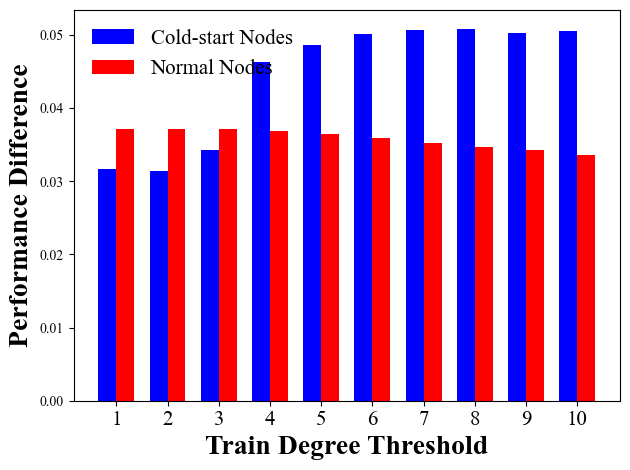

In [88]:
key = 'MRR'
metric = test_metrics[keys.index(key)]

val1s, val2s = [], []
tmp = metric.mean(axis = 0)
for interval in np.arange(1, 11, 1):
    val1s.append(tmp[train_deg <= interval].mean())
    val2s.append(tmp[train_deg > interval] .mean())

intervals = np.arange(1, 11, 1)
bar_width = 0.35  # Width of the bars
index = np.arange(len(intervals))

bar1 = plt.bar(index, val1s, bar_width, label='Cold-start Nodes', color='b')
bar2 = plt.bar(index + bar_width, val2s, bar_width, label='Normal Nodes', color='r')

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Train Degree Threshold', fontsize = 20, fontweight = 'bold')
plt.ylabel('Performance Difference', fontsize = 20, fontweight = 'bold')
plt.xticks(index + bar_width / 2, intervals, fontsize = 15)  # Position of tick labels
plt.legend(frameon = 0, fontsize = 15)

plt.tight_layout()

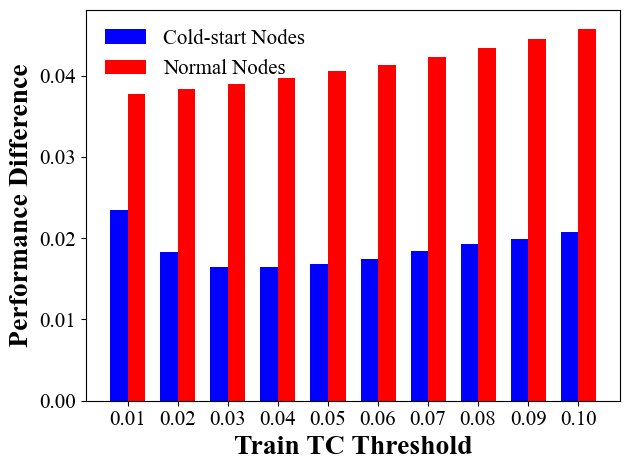

In [93]:
key = 'MRR'
metric = test_metrics[keys.index(key)]

val1s, val2s = [], []
tmp = metric.mean(axis = 0)
for interval in np.arange(0.01, 0.11, 0.01):
    val1s.append(tmp[train_tc <= interval].mean())
    val2s.append(tmp[train_tc > interval].mean())

intervals = np.arange(0.01, 0.11, 0.01)
bar_width = 0.35  # Width of the bars
index = np.arange(len(intervals))

bar1 = plt.bar(index, val1s, bar_width, label='Cold-start Nodes', color='b')
bar2 = plt.bar(index + bar_width, val2s, bar_width, label='Normal Nodes', color='r')

# Add some text for labels, title, and custom x-axis tick labels
plt.xlabel('Train TC Threshold', fontsize = 20, fontweight = 'bold')
plt.ylabel('Performance Difference', fontsize = 20, fontweight = 'bold')
plt.xticks(index + bar_width / 2, ["{:.2f}".format(i) for i in intervals], fontsize=15)
plt.yticks(fontsize = 15)
plt.legend(frameon = 0, fontsize = 15)

plt.tight_layout()

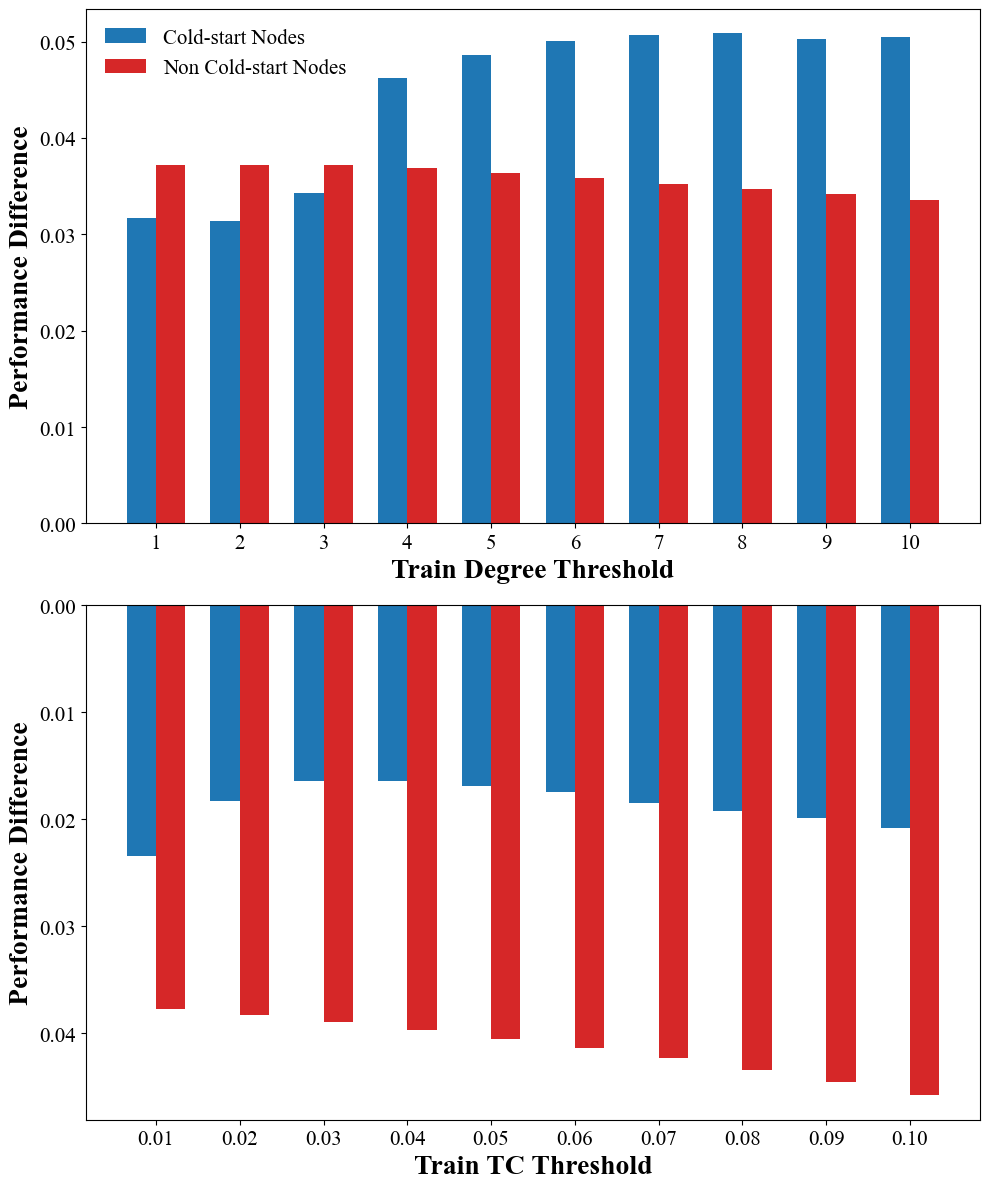

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Create a new figure with subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 12))

# First subplot
plt.subplot(2, 1, 1)

key = 'MRR'
metric = test_metrics[keys.index(key)]
val1s, val2s = [], []
tmp = metric.mean(axis=0)
for interval in np.arange(1, 11, 1):
    val1s.append(tmp[train_deg <= interval].mean())
    val2s.append(tmp[train_deg > interval].mean())

intervals = np.arange(1, 11, 1)
bar_width = 0.35
index = np.arange(len(intervals))

plt.bar(index, val1s, bar_width, label='Cold-start Nodes', color='tab:blue')
plt.bar(index + bar_width, val2s, bar_width, label='Non Cold-start Nodes', color='tab:red')

plt.xlabel('Train Degree Threshold', fontsize=20, fontweight='bold')
plt.ylabel('Performance Difference', fontsize=20, fontweight='bold')
plt.xticks(index + bar_width / 2, intervals, fontsize=15)
plt.legend(frameon=0, fontsize=15)
plt.yticks(fontsize=15)

plt.tight_layout()

# Second subplot
plt.subplot(2, 1, 2)

key = 'MRR'
metric = test_metrics[keys.index(key)]
val1s, val2s = [], []
tmp = metric.mean(axis=0)
for interval in np.arange(0.01, 0.11, 0.01):
    val1s.append(tmp[train_tc <= interval].mean())
    val2s.append(tmp[train_tc > interval].mean())

intervals = np.arange(0.01, 0.11, 0.01)
bar_width = 0.35
index = np.arange(len(intervals))

plt.bar(index, val1s, bar_width, label='Cold-start Nodes', color='tab:blue')
plt.bar(index + bar_width, val2s, bar_width, label='Non Cold-start Nodes', color='tab:red')

plt.xlabel('Train TC Threshold', fontsize=20, fontweight='bold')
plt.ylabel('Performance Difference', fontsize=20, fontweight='bold')
plt.xticks(index + bar_width / 2, ["{:.2f}".format(i) for i in intervals], fontsize=15)
plt.yticks(fontsize=15)

plt.gca().invert_yaxis()  # Invert y-axis

plt.tight_layout()
plt.savefig('./fig/ogbl-citation2/cold_start_citation2.png', transparent = True, dpi = 200, bbox_inches = 'tight')

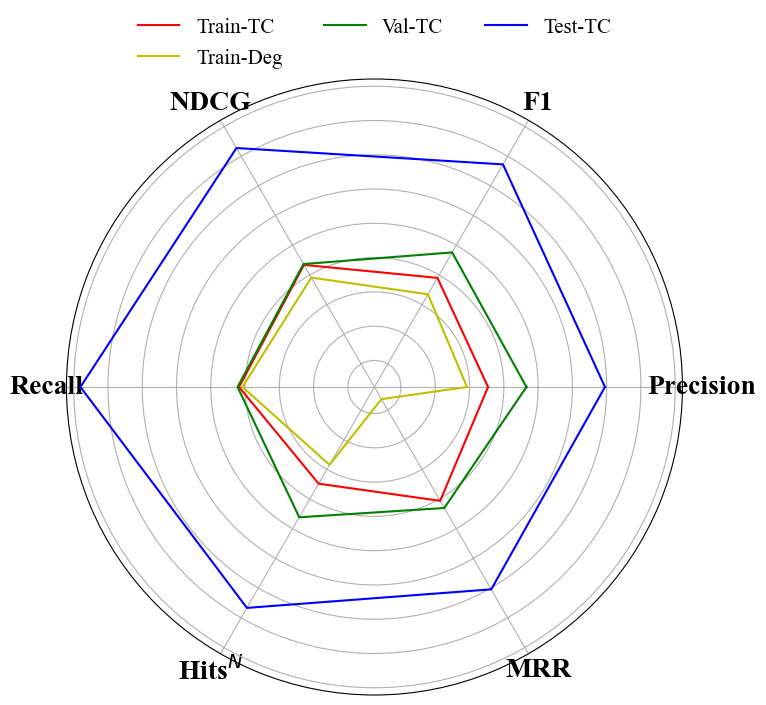

In [41]:
import matplotlib.pyplot as plt
import numpy as np

# Define data
labels = ['Precision', 'F1', 'NDCG', 'Recall', r'Hits$^N$', 'MRR']
train_tc = [0.1539, 0.1901, 0.2339, 0.2175, 0.1482, 0.2060]
val_tc = [0.2659, 0.2759, 0.2367, 0.2218, 0.2614, 0.2301]
test_tc = [0.4951, 0.5725, 0.6276, 0.6803, 0.5667, 0.5042]
train_deg = [0.0925, 0.1348, 0.1911, 0.2075, 0.0846, -0.1367]

# Setup plot
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

# Complete the loop by adding the first angle at the end of the list
angles += angles[:1]

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Helper function to plot data on radar chart
def add_to_radar(angles, data, label_name, color):
    data += data[:1]  # Add the first data point at the end to close the loop
    # ax.fill(angles, data, color=color, alpha=0.25)
    ax.plot(angles, data, label=label_name, color=color)

# Plot each data series
add_to_radar(angles, train_tc, 'Train-TC', 'r')
add_to_radar(angles, train_deg, 'Train-Deg', 'y')
add_to_radar(angles, val_tc, 'Val-TC', 'g')
# add_to_radar(angles, val_deg, 'Val-Deg', 'm')
add_to_radar(angles, test_tc, 'Test-TC', 'b')
# add_to_radar(angles, test_deg, 'Test-Deg', 'c')

# Add labels to plot
ax.set_yticklabels([])
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize = 20, fontweight = 'bold')

# Add legend
# ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1), fontsize = 15, frameon = 0)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.13), ncol=3, frameon = 0, fontsize = 15)

# Show plot
plt.savefig('./fig/ogbl-collab/Radar_correlation_collab.png', transparent = True, dpi = 200, bbox_inches = 'tight')